Final Graphs

Volcano plots

In [1]:
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/drive/My Drive/"
project_folder = "Thesis_MSc"
os.chdir(root_dir + project_folder)
!pwd

Mounted at /content/drive
/content/drive/My Drive/Thesis_MSc


In [2]:
!pip install kaleido==0.2.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio
import os

# -------- Parameters --------
INPUT_XLSX = "data/AML_NetBID2_ms_tab_VV.xlsx"
logfc_thresh = 0.05
pval_thresh = 0.05
n_annotate = 10
size_cutoff = 30

# -------- Load data --------
df = pd.read_excel(INPUT_XLSX)
df["logFC_DE"] = pd.to_numeric(df.get("logFC.Pos.Vs.Neg_DE"), errors="coerce")
df["pval_DE"] = pd.to_numeric(df.get("adj.P.Val.Pos.Vs.Neg_DE"), errors="coerce")
df["logFC_DA"] = pd.to_numeric(df.get("logFC.Pos.Vs.Neg_DA"), errors="coerce")
df["pval_DA"] = pd.to_numeric(df.get("adj.P.Val.Pos.Vs.Neg_DA"), errors="coerce")
df["gene"] = df["geneSymbol"].astype(str)
df["size"] = pd.to_numeric(df.get("Size"), errors="coerce").fillna(20)

# Drop rows with missing values
df = df.dropna(subset=["logFC_DE", "pval_DE", "logFC_DA", "pval_DA"])

# Replace zero/negative p-values
positive_pvals_da = df.loc[df["pval_DA"] > 0, "pval_DA"]
min_nonzero_da = positive_pvals_da.min() if not positive_pvals_da.empty else 1e-300
df.loc[df["pval_DA"] <= 0, "pval_DA"] = min_nonzero_da
df["neglog10adjP_DA"] = -np.log10(df["pval_DA"])

# -------- DE Category mapping --------
def categorize_de(row):
    if row["pval_DE"] > pval_thresh and row["pval_DA"] < pval_thresh:
        return "Hidden"
    elif row["pval_DE"] < pval_thresh and row["pval_DA"] < pval_thresh:
        return "Overt"
    else:
        return "Not Significant"

df["category_DE"] = df.apply(categorize_de, axis=1)

palette = {
    "Hidden": "#E24A33",           # orange-red
    "Overt": "#348ABD",            # blue
    "Not Significant": "#BBBBBB"   # light gray
}

# -------- Identify Hidden and Overt subsets --------
hidden_df = df[df["category_DE"] == "Hidden"]
overt_df = df[df["category_DE"] == "Overt"]

# -------- Top 10 Up/Down Hidden & Overt --------
top_Up_hidden = hidden_df[(hidden_df["size"] > size_cutoff) & (hidden_df["logFC_DA"] > 0)].nsmallest(n_annotate, "pval_DA")
top_Down_hidden = hidden_df[(hidden_df["size"] > size_cutoff) & (hidden_df["logFC_DA"] < 0)].nsmallest(n_annotate, "pval_DA")
top_Up_overt = overt_df[(overt_df["size"] > size_cutoff) & (overt_df["logFC_DA"] > 0)].nsmallest(n_annotate, "pval_DA")
top_Down_overt = overt_df[(overt_df["size"] > size_cutoff) & (overt_df["logFC_DA"] < 0)].nsmallest(n_annotate, "pval_DA")

# Combine all top genes for CSV
top_genes = pd.concat([top_Up_hidden, top_Down_hidden, top_Up_overt, top_Down_overt])
top_genes_file = os.path.join("driver", "top40_DE_genes.csv")
os.makedirs("driver", exist_ok=True)
top_genes.to_csv(top_genes_file, index=False)
print(f"Top 40 genes saved to {top_genes_file}")

# -------- Filter main dataset by size --------
df_filtered = df[df["size"] > size_cutoff].copy()

# -------- Volcano plotting function --------
def make_volcano_de_on_da(data, top_Up_hidden, top_Down_hidden, top_Up_overt, top_Down_overt, title, html_file, png_file):
    fig = px.scatter(
        data,
        x="logFC_DA",
        y="neglog10adjP_DE",
        color="category_DE",
        size="size",
        hover_name="gene",
        hover_data={"logFC_DA": True, "neglog10adjP_DE": True, "size": False},
        color_discrete_map=palette,
        labels={"logFC_DA": "log2 Fold Change (DE)", "neglog10adjP_DA": "-log10 Adjusted P-value (DE)"},
        title=title
    )

    # Threshold line
    fig.add_hline(y=-np.log10(pval_thresh), line_dash="dash", line_color="gray")

    # Helper to annotate a set of genes
    def annotate_genes(df_subset, color, name):
        if not df_subset.empty:
            fig.add_scatter(
                x=df_subset["logFC_DE"],
                y=df_subset["neglog10adjP_DE"],
                mode="markers",
                marker=dict(color=color, size=16, symbol="circle"),
                name=name
            )
            for _, row in df_subset.iterrows():
                fig.add_annotation(
                    x=row["logFC_DA"],
                    y=row["neglog10adjP_DA"],
                    text=row["gene"],
                    showarrow=True,
                    arrowhead=3,
                    ax=0,
                    ay=-30,
                    font=dict(size=12, color=color, family="Arial Black"),
                    bgcolor="white",
                    bordercolor=color,
                    borderwidth=1
                )

    annotate_genes(top_Up_hidden, "red", "Top Up Hidden")
    annotate_genes(top_Down_hidden, "darkred", "Top Down Hidden")
    annotate_genes(top_Up_overt, "green", "Top Up Overt")
    annotate_genes(top_Down_overt, "darkgreen", "Top Down Overt")

    # Symmetric x-axis
    max_fc = max(abs(data["logFC_DE"].min()), abs(data["logFC_DE"].max()))
    fig.update_xaxes(range=[-max_fc * 1.2, max_fc * 1.2])

    # Layout styling
    fig.update_layout(
        plot_bgcolor="whitesmoke",
        paper_bgcolor="white",
        showlegend=True,
        legend=dict(
            font=dict(size=12, color="black", family="Arial Black"),
            title_font=dict(size=14, color="black", family="Arial Black")
        ),
        title=dict(
            text=title,
            font=dict(size=20, color="black", family="Arial Black"),
            x=0.5,
            xanchor='center'
        ),
        xaxis=dict(title_font=dict(size=16, color="black", family="Arial Black"), tickfont=dict(size=12, color="black")),
        yaxis=dict(title_font=dict(size=16, color="black", family="Arial Black"), tickfont=dict(size=12, color="black"))
    )

    fig.write_html(html_file)
    try:
        pio.write_image(fig, png_file, width=1200, height=800)
    except Exception as e:
        print("PNG export skipped:", e)

    fig.show()

# -------- Run volcano plot --------
html_file = os.path.join("driver", "volcano_DE_on_DE_top40.html")
png_file = os.path.join("driver", "volcano_DE_on_DE_top40.png")

make_volcano_de_on_da(
    df_filtered,
    top_Up_hidden,
    top_Down_hidden,
    top_Up_overt,
    top_Down_overt,
    "Volcano Plot: Top 10 Up/Down Hidden & Overt DE Drivers",
    html_file,
    png_file
)


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio
import os

# -------- Parameters --------
INPUT_XLSX = "data/AML_NetBID2_ms_tab_VV.xlsx"
logfc_thresh = 0.05
pval_thresh = 0.05
n_annotate = 10
size_cutoff = 30

# -------- Load data --------
df = pd.read_excel(INPUT_XLSX)
df["logFC_DE"] = pd.to_numeric(df.get("logFC.Pos.Vs.Neg_DE"), errors="coerce")
df["pval_DE"] = pd.to_numeric(df.get("adj.P.Val.Pos.Vs.Neg_DE"), errors="coerce")
df["logFC_DA"] = pd.to_numeric(df.get("logFC.Pos.Vs.Neg_DA"), errors="coerce")
df["pval_DA"] = pd.to_numeric(df.get("adj.P.Val.Pos.Vs.Neg_DA"), errors="coerce")
df["gene"] = df["geneSymbol"].astype(str)
df["size"] = pd.to_numeric(df.get("Size"), errors="coerce").fillna(20)

# Drop rows with missing values
df = df.dropna(subset=["logFC_DE", "pval_DE", "logFC_DA", "pval_DA"])

# -------- Replace zero/negative p-values --------
for col in ["pval_DE", "pval_DA"]:
    positive_pvals = df.loc[df[col] > 0, col]
    min_nonzero = positive_pvals.min() if not positive_pvals.empty else 1e-300
    df.loc[df[col] <= 0, col] = min_nonzero

df["neglog10adjP_DE"] = -np.log10(df["pval_DE"])
df["neglog10adjP_DA"] = -np.log10(df["pval_DA"])

# -------- DE Category mapping --------
def categorize_de(row):
    if row["pval_DE"] > pval_thresh and row["pval_DA"] < pval_thresh:
        return "Hidden"
    elif row["pval_DE"] < pval_thresh and row["pval_DA"] < pval_thresh:
        return "Overt"
    else:
        return "Not Significant"

df["category_DE"] = df.apply(categorize_de, axis=1)

palette = {
    "Hidden": "#E24A33",
    "Overt": "#348ABD",
    "Not Significant": "#BBBBBB"
}

# -------- Hidden & Overt subsets --------
hidden_df = df[df["category_DE"] == "Hidden"]
overt_df = df[df["category_DE"] == "Overt"]

# -------- Top 10 Up/Down Hidden & Overt (DE) --------
top_Up_hidden = hidden_df[(hidden_df["size"] > size_cutoff) & (hidden_df["logFC_DE"] > 0)].nsmallest(n_annotate, "pval_DE")
top_Down_hidden = hidden_df[(hidden_df["size"] > size_cutoff) & (hidden_df["logFC_DE"] < 0)].nsmallest(n_annotate, "pval_DE")
top_Up_overt = overt_df[(overt_df["size"] > size_cutoff) & (overt_df["logFC_DE"] > 0)].nsmallest(n_annotate, "pval_DE")
top_Down_overt = overt_df[(overt_df["size"] > size_cutoff) & (overt_df["logFC_DE"] < 0)].nsmallest(n_annotate, "pval_DE")

# -------- Save top genes --------
top_genes = pd.concat([top_Up_hidden, top_Down_hidden, top_Up_overt, top_Down_overt])
os.makedirs("driver", exist_ok=True)
top_genes_file = os.path.join("driver", "top40_DE_genes.csv")
top_genes.to_csv(top_genes_file, index=False)
print(f"Top 40 DE genes saved to {top_genes_file}")

# -------- Filter main dataset by size --------
df_filtered = df[df["size"] > size_cutoff].copy()

# -------- Volcano plotting function (DE only) --------
def make_volcano_de(data, top_Up_hidden, top_Down_hidden, top_Up_overt, top_Down_overt, title, html_file, png_file):
    fig = px.scatter(
        data,
        x="logFC_DE",
        y="neglog10adjP_DE",
        color="category_DE",
        size="size",
        hover_name="gene",
        hover_data={"logFC_DE": True, "neglog10adjP_DE": True, "size": False},
        color_discrete_map=palette,
        labels={"logFC_DE": "log2 Fold Change (DE)", "neglog10adjP_DE": "-log10 Adj P-value (DE)"},
        title=title
    )

    # Threshold line
    fig.add_hline(y=-np.log10(pval_thresh), line_dash="dash", line_color="gray")

    # Annotate genes
    def annotate_genes(df_subset, color, name):
        if not df_subset.empty:
            fig.add_scatter(
                x=df_subset["logFC_DE"],
                y=df_subset["neglog10adjP_DE"],
                mode="markers",
                marker=dict(color=color, size=16, symbol="circle"),
                name=name
            )
            for _, row in df_subset.iterrows():
                fig.add_annotation(
                    x=row["logFC_DE"],
                    y=row["neglog10adjP_DE"],
                    text=row["gene"],
                    showarrow=True,
                    arrowhead=3,
                    ax=0,
                    ay=-30,
                    font=dict(size=12, color=color, family="Arial Black"),
                    bgcolor="white",
                    bordercolor=color,
                    borderwidth=1
                )

    annotate_genes(top_Up_hidden, "red", "Top Up Hidden")
    annotate_genes(top_Down_hidden, "darkred", "Top Down Hidden")
    annotate_genes(top_Up_overt, "green", "Top Up Overt")
    annotate_genes(top_Down_overt, "darkgreen", "Top Down Overt")

    # Symmetric x-axis
    max_fc = max(abs(data["logFC_DE"].min()), abs(data["logFC_DE"].max()))
    fig.update_xaxes(range=[-max_fc * 1.2, max_fc * 1.2])

    # Layout styling
    fig.update_layout(
        plot_bgcolor="whitesmoke",
        paper_bgcolor="white",
        showlegend=True,
        legend=dict(
            font=dict(size=12, color="black", family="Arial Black"),
            title_font=dict(size=14, color="black", family="Arial Black")
        ),
        title=dict(
            text=title,
            font=dict(size=20, color="black", family="Arial Black"),
            x=0.5,
            xanchor='center'
        ),
        xaxis=dict(title_font=dict(size=16, color="black", family="Arial Black"), tickfont=dict(size=12, color="black")),
        yaxis=dict(title_font=dict(size=16, color="black", family="Arial Black"), tickfont=dict(size=12, color="black"))
    )

    fig.write_html(html_file)
    try:
        pio.write_image(fig, png_file, width=1200, height=800,  scale=8.33)
    except Exception as e:
        print("PNG export skipped:", e)

    fig.show()

# -------- Run volcano plot --------
html_file = os.path.join("driver", "volcano_DE_top40.html")
png_file = os.path.join("driver", "volcano_DE_top40.png")

make_volcano_de(
    df_filtered,
    top_Up_hidden,
    top_Down_hidden,
    top_Up_overt,
    top_Down_overt,
    "Volcano Plot DE: Top 10 Up/Down Hidden & Overt Drivers",
    html_file,
    png_file
)


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio
import os

# -------- Parameters --------
INPUT_XLSX = "data/AML_NetBID2_ms_tab_VV.xlsx"
logfc_thresh = 0.05
pval_thresh = 0.05
n_annotate = 10
size_cutoff = 30  # Only include genes with size > size_cutoff

# -------- Load data --------
df = pd.read_excel(INPUT_XLSX)
df["logFC"] = pd.to_numeric(df.get("logFC.Pos.Vs.Neg_DA"), errors="coerce")
df["pval_DA"] = pd.to_numeric(df.get("adj.P.Val.Pos.Vs.Neg_DA"), errors="coerce")
df["pval_DE"] = pd.to_numeric(df.get("adj.P.Val.Pos.Vs.Neg_DE"), errors="coerce")
df["gene"] = df["geneSymbol"].astype(str)
df["size"] = pd.to_numeric(df.get("Size"), errors="coerce").fillna(20)
df = df.dropna(subset=["logFC", "pval_DA"])

df["logFC_DE"] = pd.to_numeric(df.get("logFC.Pos.Vs.Neg_DE"), errors="coerce")

# -------- Replace zero/negative p-values --------
positive_pvals = df.loc[df["pval_DA"] > 0, "pval_DA"]
min_nonzero_da = positive_pvals.min() if not positive_pvals.empty else 1e-300
df.loc[df["pval_DA"] <= 0, "pval_DA"] = min_nonzero_da
df["neglog10adjP"] = -np.log10(df["pval_DA"])

# -------- DE Category mapping --------
def categorize_de(row):
    if row["pval_DE"] > pval_thresh and row["pval_DA"] < pval_thresh:
        return "Hidden"
    elif row["pval_DE"] < pval_thresh and row["pval_DA"] < pval_thresh:
        return "Overt"
    else:
        return "Not Significant"

df["category_DE"] = df.apply(categorize_de, axis=1)

palette_de = {
    "Hidden": "#E24A33",           # orange-red
    "Overt": "#348ABD",            # blue
    "Not Significant": "#BBBBBB"   # light gray
}

# -------- Identify Hidden and Overt subsets --------
hidden_df = df[df["category_DE"] == "Hidden"]
overt_df = df[df["category_DE"] == "Overt"]

# -------- Top 10 Up/Down Hidden & Overt --------
top_Up_hidden = hidden_df[(hidden_df["size"] > size_cutoff) & (hidden_df["logFC"] > 0)].nsmallest(n_annotate, "pval_DA")
top_Down_hidden = hidden_df[(hidden_df["size"] > size_cutoff) & (hidden_df["logFC"] < 0)].nsmallest(n_annotate, "pval_DA")
top_Up_overt = overt_df[(overt_df["size"] > size_cutoff) & (overt_df["logFC"] > 0)].nsmallest(n_annotate, "pval_DA")
top_Down_overt = overt_df[(overt_df["size"] > size_cutoff) & (overt_df["logFC"] < 0)].nsmallest(n_annotate, "pval_DA")

# Combine all top genes for CSV
top_genes = pd.concat([top_Up_hidden, top_Down_hidden, top_Up_overt, top_Down_overt])
os.makedirs("driver", exist_ok=True)
top_genes_file = os.path.join("driver", "top40_DE_genes.csv")
top_genes.to_csv(top_genes_file, index=False)
print(f"Top 40 genes saved to {top_genes_file}")

# -------- Filter main dataset by size --------
df_filtered = df[df["size"] > size_cutoff].copy()

# -------- Category mapping for volcano --------
def categorize(row):
    if row["pval_DA"] < pval_thresh and row["logFC"] > 0:
        return "Upregulated"
    elif row["pval_DA"] < pval_thresh and row["logFC"] < 0:
        return "Downregulated"
    else:
        return "Not Significant"

df_filtered["category"] = df_filtered.apply(categorize, axis=1)

palette_volcano = {
    "Upregulated": "#fdae61",
    "Downregulated": "#313695",
    "Not Significant": "#bdbdbd"
}

# -------- Identify top drivers --------
hidden_filtered = hidden_df[hidden_df["size"] > size_cutoff].nsmallest(n_annotate, "pval_DA")
overt_filtered = overt_df[overt_df["size"] > size_cutoff].nsmallest(n_annotate, "pval_DA")

print("Top Hidden Drivers (size > cutoff):")
print(hidden_filtered[["gene", "logFC", "pval_DA", "neglog10adjP", "size"]].to_string(index=False))

print("\nTop Overt Drivers (size > cutoff):")
print(overt_filtered[["gene", "logFC", "pval_DA", "neglog10adjP", "size"]].to_string(index=False))

# -------- Top 10 Up/Down Hidden & Overt for driver volcano --------
top_Up_hidden_drv = hidden_df[(hidden_df["size"] > size_cutoff) & (hidden_df["logFC"] > 0)].nsmallest(n_annotate, "pval_DA")
top_Down_hidden_drv = hidden_df[(hidden_df["size"] > size_cutoff) & (hidden_df["logFC"] < 0)].nsmallest(n_annotate, "pval_DA")
top_Up_overt_drv = overt_df[(overt_df["size"] > size_cutoff) & (overt_df["logFC"] > 0)].nsmallest(n_annotate, "pval_DA")
top_Down_overt_drv = overt_df[(overt_df["size"] > size_cutoff) & (overt_df["logFC"] < 0)].nsmallest(n_annotate, "pval_DA")

top_genes_drv = pd.concat([top_Up_hidden_drv, top_Down_hidden_drv, top_Up_overt_drv, top_Down_overt_drv])
top_genes_file_drv = os.path.join("driver", "top40_driver_genes.csv")
top_genes_drv.to_csv(top_genes_file_drv, index=False)
print(f"Top 40 driver genes saved to {top_genes_file_drv}")

# -------- Volcano plotting function --------
def make_driver_volcano_top40(data, top_Up_hidden, top_Down_hidden, top_Up_overt, top_Down_overt, title, html_file, png_file):
    fig = px.scatter(
        data,
        x="logFC",
        y="neglog10adjP",
        color="category",
        size="size",
        hover_name="gene",
        hover_data={"logFC": True, "neglog10adjP": True, "size": False},
        color_discrete_map=palette_volcano,
        labels={"logFC": "log2 Fold Change", "neglog10adjP": "-log10 Adjusted P-value"},
        title=title
    )

    fig.add_hline(y=-np.log10(pval_thresh), line_dash="dash", line_color="gray")

    # Annotate a set of genes
    def annotate_genes(df_subset, color, name):
        if not df_subset.empty:
            fig.add_scatter(
                x=df_subset["logFC"],
                y=df_subset["neglog10adjP"],
                mode="markers",
                marker=dict(color=color, size=16, symbol="circle"),
                name=name
            )
            for _, row in df_subset.iterrows():
                fig.add_annotation(
                    x=row["logFC"],
                    y=row["neglog10adjP"],
                    text=row["gene"],
                    showarrow=True,
                    arrowhead=3,
                    ax=0,
                    ay=-30,
                    font=dict(size=12, color=color, family="Arial Black"),
                    bgcolor="white",
                    bordercolor=color,
                    borderwidth=1
                )

    annotate_genes(top_Up_hidden, "red", "Top Up Hidden")
    annotate_genes(top_Down_hidden, "darkred", "Top Down Hidden")
    annotate_genes(top_Up_overt, "green", "Top Up Overt")
    annotate_genes(top_Down_overt, "darkgreen", "Top Down Overt")

    max_fc = max(abs(data["logFC"].min()), abs(data["logFC"].max()))
    fig.update_xaxes(range=[-max_fc * 1.2, max_fc * 1.2])

    fig.update_layout(
        plot_bgcolor="whitesmoke",
        paper_bgcolor="white",
        showlegend=True,
        legend=dict(
            font=dict(size=12, color="black", family="Arial Black"),
            title_font=dict(size=14, color="black", family="Arial Black")
        ),
        title=dict(
            text=title,
            font=dict(size=20, color="black", family="Arial Black"),
            x=0.5,
            xanchor='center'
        ),
        xaxis=dict(title_font=dict(size=16, color="black", family="Arial Black"), tickfont=dict(size=12, color="black")),
        yaxis=dict(title_font=dict(size=16, color="black", family="Arial Black"), tickfont=dict(size=12, color="black"))
    )

    fig.write_html(html_file)
    try:
        pio.write_image(fig, png_file, width=1200, height=800,  scale=8.33)
    except Exception as e:
        print("PNG export skipped:", e)

    fig.show()

# -------- Run volcano plot for drivers --------
html_file_drv = os.path.join("driver", "volcano_drivers_top40_DA.html")
png_file_drv = os.path.join("driver", "volcano_drivers_top40_DA.png")

make_driver_volcano_top40(
    df_filtered,
    top_Up_hidden_drv,
    top_Down_hidden_drv,
    top_Up_overt_drv,
    top_Down_overt_drv,
    "Volcano Plot: Top 10 Up/Down Hidden & Overt Drivers DA Drivers",
    html_file_drv,
    png_file_drv
)


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio
import os

# -------- Parameters --------
INPUT_XLSX = "data/AML_NetBID2_ms_tab_VV.xlsx"
logfc_thresh = 0.05
pval_thresh = 0.05
n_annotate = 10
size_cutoff = 30

# -------- Load data --------
df = pd.read_excel(INPUT_XLSX)
df["logFC_DE"] = pd.to_numeric(df.get("logFC.Pos.Vs.Neg_DE"), errors="coerce")
df["pval_DE"] = pd.to_numeric(df.get("adj.P.Val.Pos.Vs.Neg_DE"), errors="coerce")
df["logFC_DA"] = pd.to_numeric(df.get("logFC.Pos.Vs.Neg_DA"), errors="coerce")
df["pval_DA"] = pd.to_numeric(df.get("adj.P.Val.Pos.Vs.Neg_DA"), errors="coerce")
df["gene"] = df["geneSymbol"].astype(str)
df["size"] = pd.to_numeric(df.get("Size"), errors="coerce").fillna(20)

# Drop rows with missing values
df = df.dropna(subset=["logFC_DE", "pval_DE", "logFC_DA", "pval_DA"])

# -------- Replace zero/negative p-values --------
for col in ["pval_DE", "pval_DA"]:
    positive_pvals = df.loc[df[col] > 0, col]
    min_nonzero = positive_pvals.min() if not positive_pvals.empty else 1e-300
    df.loc[df[col] <= 0, col] = min_nonzero

df["neglog10adjP_DE"] = -np.log10(df["pval_DE"])
df["neglog10adjP_DA"] = -np.log10(df["pval_DA"])

# -------- DE Category mapping --------
def categorize_de(row):
    if row["pval_DE"] > pval_thresh and row["pval_DA"] < pval_thresh:
        return "Hidden"
    elif row["pval_DE"] < pval_thresh and row["pval_DA"] < pval_thresh:
        return "Overt"
    else:
        return "Not Significant"

df["category_DE"] = df.apply(categorize_de, axis=1)

palette = {
    "Hidden": "#E24A33",
    "Overt": "#348ABD",
    "Not Significant": "#BBBBBB"
}

# -------- Hidden & Overt subsets --------
hidden_df = df[df["category_DE"] == "Hidden"]
overt_df = df[df["category_DE"] == "Overt"]

# -------- Top 10 Up/Down Hidden & Overt (DA) --------
top_Up_hidden = hidden_df[(hidden_df["size"] > size_cutoff) & (hidden_df["logFC_DA"] > 0)].nsmallest(n_annotate, "pval_DA")
top_Down_hidden = hidden_df[(hidden_df["size"] > size_cutoff) & (hidden_df["logFC_DA"] < 0)].nsmallest(n_annotate, "pval_DA")
top_Up_overt = overt_df[(overt_df["size"] > size_cutoff) & (overt_df["logFC_DA"] > 0)].nsmallest(n_annotate, "pval_DA")
top_Down_overt = overt_df[(overt_df["size"] > size_cutoff) & (overt_df["logFC_DA"] < 0)].nsmallest(n_annotate, "pval_DA")

# -------- Save top genes --------
top_genes = pd.concat([top_Up_hidden, top_Down_hidden, top_Up_overt, top_Down_overt])
os.makedirs("driver", exist_ok=True)
top_genes_file = os.path.join("driver", "top40_DA_genes.csv")
top_genes.to_csv(top_genes_file, index=False)
print(f"Top 40 DA genes saved to {top_genes_file}")

# -------- Filter main dataset by size --------
df_filtered = df[df["size"] > size_cutoff].copy()

# -------- Volcano plotting function (DA only) --------
def make_volcano_da(data, top_Up_hidden, top_Down_hidden, top_Up_overt, top_Down_overt, title, html_file, png_file):
    fig = px.scatter(
        data,
        x="logFC_DA",
        y="neglog10adjP_DA",
        color="category_DE",
        size="size",
        hover_name="gene",
        hover_data={"logFC_DA": True, "neglog10adjP_DA": True, "size": False},
        color_discrete_map=palette,
        labels={"logFC_DA": "log2 Fold Change (DA)", "neglog10adjP_DA": "-log10 Adj P-value (DA)"},
        title=title
    )

    # Threshold line
    fig.add_hline(y=-np.log10(pval_thresh), line_dash="dash", line_color="gray")

    # Annotate genes
    def annotate_genes(df_subset, color, name):
        if not df_subset.empty:
            fig.add_scatter(
                x=df_subset["logFC_DA"],
                y=df_subset["neglog10adjP_DA"],
                mode="markers",
                marker=dict(color=color, size=16, symbol="circle"),
                name=name
            )
            for _, row in df_subset.iterrows():
                fig.add_annotation(
                    x=row["logFC_DA"],
                    y=row["neglog10adjP_DA"],
                    text=row["gene"],
                    showarrow=True,
                    arrowhead=3,
                    ax=0,
                    ay=-30,
                    font=dict(size=12, color=color, family="Arial Black"),
                    bgcolor="white",
                    bordercolor=color,
                    borderwidth=1
                )

    annotate_genes(top_Up_hidden, "red", "Top Up Hidden")
    annotate_genes(top_Down_hidden, "darkred", "Top Down Hidden")
    annotate_genes(top_Up_overt, "green", "Top Up Overt")
    annotate_genes(top_Down_overt, "darkgreen", "Top Down Overt")

    # Symmetric x-axis
    max_fc = max(abs(data["logFC_DA"].min()), abs(data["logFC_DA"].max()))
    fig.update_xaxes(range=[-max_fc * 1.2, max_fc * 1.2])

    # Layout styling
    fig.update_layout(
        plot_bgcolor="whitesmoke",
        paper_bgcolor="white",
        showlegend=True,
        legend=dict(
            font=dict(size=12, color="black", family="Arial Black"),
            title_font=dict(size=14, color="black", family="Arial Black")
        ),
        title=dict(
            text=title,
            font=dict(size=20, color="black", family="Arial Black"),
            x=0.5,
            xanchor='center'
        ),
        xaxis=dict(title_font=dict(size=16, color="black", family="Arial Black"), tickfont=dict(size=12, color="black")),
        yaxis=dict(title_font=dict(size=16, color="black", family="Arial Black"), tickfont=dict(size=12, color="black"))
    )

    fig.write_html(html_file)
    try:
        pio.write_image(fig, png_file, width=1200, height=800,  scale=8.33)
    except Exception as e:
        print("PNG export skipped:", e)

    fig.show()

# -------- Run DA volcano plot --------
html_file = os.path.join("driver", "volcano_DA_top40.html")
png_file = os.path.join("driver", "volcano_DA_top40.png")

make_volcano_da(
    df_filtered,
    top_Up_hidden,
    top_Down_hidden,
    top_Up_overt,
    top_Down_overt,
    "Volcano Plot: Top 10 Up/Down Hidden & Overt DA Drivers",
    html_file,
    png_file
)


In [ ]:
# -------- Top 10 Up/Down Hidden & Overt --------
top_Up_hidden = hidden_df[(hidden_df["size"] > size_cutoff) & (hidden_df["logFC_DA"] > 0)].nsmallest(n_annotate, "pval_DA")
top_Down_hidden = hidden_df[(hidden_df["size"] > size_cutoff) & (hidden_df["logFC_DA"] < 0)].nsmallest(n_annotate, "pval_DA")
top_Up_overt = overt_df[(overt_df["size"] > size_cutoff) & (overt_df["logFC_DA"] > 0)].nsmallest(n_annotate, "pval_DA")
top_Down_overt = overt_df[(overt_df["size"] > size_cutoff) & (overt_df["logFC_DA"] < 0)].nsmallest(n_annotate, "pval_DA")

# -------- Save each list as its own CSV --------
output_dir = "driver"
os.makedirs(output_dir, exist_ok=True)

top_Up_hidden.to_csv(os.path.join(output_dir, "top10_Up_hidden.csv"), index=False)
top_Down_hidden.to_csv(os.path.join(output_dir, "top10_Down_hidden.csv"), index=False)
top_Up_overt.to_csv(os.path.join(output_dir, "top10_Up_overt.csv"), index=False)
top_Down_overt.to_csv(os.path.join(output_dir, "top10_Down_overt.csv"), index=False)

print("✅ Saved CSVs:")
print(" - driver/top10_Up_hidden.csv")
print(" - driver/top10_Down_hidden.csv")
print(" - driver/top10_Up_overt.csv")
print(" - driver/top10_Down_overt.csv")


In [ ]:
from PIL import Image

# Paths to your individual volcano images
de_png = "driver/volcano_DA_top40.png"
da_png = "driver/volcano_DE_top40.png"

# Open the images
img_de = Image.open(de_png)
img_da = Image.open(da_png)

# Resize to same height
height = max(img_de.height, img_da.height)
img_de = img_de.resize((int(img_de.width * height / img_de.height), height))
img_da = img_da.resize((int(img_da.width * height / img_da.height), height))

# Optional spacing between panels
spacing = 50
total_width = img_de.width + img_da.width + spacing

# Create combined image
combined = Image.new("RGB", (total_width, height), color=(255, 255, 255))
combined.paste(img_de, (0, 0))
combined.paste(img_da, (img_de.width + spacing, 0))

# Save the combined image
output_path = "driver/multipanel_volcano_combined.png"
combined.save(output_path)
print(f"Combined image saved as: {output_path}")



In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio
import os

# -------- Parameters --------
INPUT_XLSX = "data/AML_NetBID2_ms_tab_VV.xlsx"
logfc_thresh = 0.05
pval_thresh = 0.05
n_annotate = 10
size_cutoff = 30  # Only include genes with size > size_cutoff

# -------- Load data --------
df = pd.read_excel(INPUT_XLSX)
df["logFC"] = pd.to_numeric(df.get("logFC.Pos.Vs.Neg_DA"), errors="coerce")
df["pval_DA"] = pd.to_numeric(df.get("adj.P.Val.Pos.Vs.Neg_DA"), errors="coerce")
df["pval_DE"] = pd.to_numeric(df.get("adj.P.Val.Pos.Vs.Neg_DE"), errors="coerce")
df["gene"] = df["geneSymbol"].astype(str)
df["size"] = pd.to_numeric(df.get("Size"), errors="coerce").fillna(20)
df = df.dropna(subset=["logFC", "pval_DA"])

# Replace zero/negative p-values
positive_pvals = df.loc[df["pval_DA"] > 0, "pval_DA"]
min_nonzero = positive_pvals.min() if not positive_pvals.empty else 1e-300
df.loc[df["pval_DA"] <= 0, "pval_DA"] = min_nonzero
df["neglog10adjP"] = -np.log10(df["pval_DA"])

# -------- Category mapping --------
def categorize(row):
    if row["pval_DA"] < pval_thresh and row["logFC"] > logfc_thresh:
        return "Upregulated"
    elif row["pval_DA"] < pval_thresh and row["logFC"] < -logfc_thresh:
        return "Downregulated"
    else:
        return "Not Significant"

df["category"] = df.apply(categorize, axis=1)

palette = {
    "Upregulated": "#fdae61",
    "Downregulated": "#313695",
    "Not Significant": "#bdbdbd"
}

# -------- Identify hidden/overt drivers --------
hidden_df = df[(df["pval_DA"] < pval_thresh) & (df["pval_DE"] > pval_thresh)]
overt_df = df[(df["pval_DA"] < pval_thresh) & (df["pval_DE"] < pval_thresh)]

# -------- Filter top drivers by size strictly --------
hidden_filtered = hidden_df[hidden_df["size"] > size_cutoff].nsmallest(n_annotate, "pval_DA")
overt_filtered = overt_df[overt_df["size"] > size_cutoff].nsmallest(n_annotate, "pval_DA")

# -------- Filter main dataset by size --------
df_filtered = df[df["size"] > size_cutoff].copy()

# -------- Print results --------
print("Top Hidden Drivers (size > cutoff):")
print(hidden_filtered[["gene", "logFC", "pval_DA", "neglog10adjP", "size"]].to_string(index=False))

print("\nTop Overt Drivers (size > cutoff):")
print(overt_filtered[["gene", "logFC", "pval_DA", "neglog10adjP", "size"]].to_string(index=False))

print(f"\nAfter size filtering ({size_cutoff}):")
print(f"Main plot points: {len(df_filtered)}")
print(f"Hidden drivers to annotate: {len(hidden_filtered)}")
print(f"Overt drivers to annotate: {len(overt_filtered)}")

# -------- Ensure output folder exists --------
output_dir = "driver"
os.makedirs(output_dir, exist_ok=True)
html_file = os.path.join(output_dir, "volcano_drivers.html")
png_file = os.path.join(output_dir, "volcano_drivers.png")

# -------- Volcano plotting function --------
def make_driver_volcano(data, top_hidden, top_overt, title, html_file, png_file):
    fig = px.scatter(
        data,
        x="logFC",
        y="neglog10adjP",
        color="category",
        size="size",
        hover_name="gene",
        hover_data={"logFC": True, "neglog10adjP": True, "size": False},
        color_discrete_map=palette,
        labels={"logFC": "log2 Fold Change", "neglog10adjP": "-log10 Adjusted P-value"},
        title=title
    )

    # Threshold lines
    fig.add_hline(y=-np.log10(pval_thresh), line_dash="dash", line_color="gray")
    fig.add_vline(x=-logfc_thresh, line_dash="dash", line_color="gray")
    fig.add_vline(x=logfc_thresh, line_dash="dash", line_color="gray")

    # Annotate top hidden
    if not top_hidden.empty:
        fig.add_scatter(
            x=top_hidden["logFC"],
            y=top_hidden["neglog10adjP"],
            mode="markers",
            marker=dict(color="red", size=16, symbol="circle"),
            name="Top Hidden Drivers"
        )
        for _, row in top_hidden.iterrows():
            fig.add_annotation(
                x=row["logFC"],
                y=row["neglog10adjP"],
                text=row["gene"],
                showarrow=True,
                arrowhead=3,
                ax=0,
                ay=-30,
                font=dict(size=12, color="red", family="Arial Black"),
                bgcolor="white",
                bordercolor="red",
                borderwidth=1
            )

    # Annotate top overt
    if not top_overt.empty:
        fig.add_scatter(
            x=top_overt["logFC"],
            y=top_overt["neglog10adjP"],
            mode="markers",
            marker=dict(color="green", size=16, symbol="circle"),
            name="Top Overt Drivers"
        )
        for _, row in top_overt.iterrows():
            fig.add_annotation(
                x=row["logFC"],
                y=row["neglog10adjP"],
                text=row["gene"],
                showarrow=True,
                arrowhead=3,
                ax=0,
                ay=-30,
                font=dict(size=12, color="green", family="Arial Black"),
                bgcolor="white",
                bordercolor="green",
                borderwidth=1
            )

    # Symmetric x-axis
    max_fc = max(abs(data["logFC"].min()), abs(data["logFC"].max()))
    fig.update_xaxes(range=[-max_fc * 1.2, max_fc * 1.2])

    # Layout styling
    fig.update_layout(
        plot_bgcolor="whitesmoke",
        paper_bgcolor="white",
        showlegend=True,
        legend=dict(
            font=dict(size=12, color="black", family="Arial Black"),
            title_font=dict(size=14, color="black", family="Arial Black")
        ),
        title=dict(
            text=title,
            font=dict(size=20, color="black", family="Arial Black"),
            x=0.5,
            xanchor='center'
        ),
        xaxis=dict(
            title_font=dict(size=16, color="black", family="Arial Black"),
            tickfont=dict(size=12, color="black")
        ),
        yaxis=dict(
            title_font=dict(size=16, color="black", family="Arial Black"),
            tickfont=dict(size=12, color="black")
        )
    )

    # Save outputs
    fig.write_html(html_file)
    try:
        pio.write_image(fig, png_file, width=1200, height=800)
    except Exception as e:
        print("PNG export skipped:", e)

    fig.show()

# -------- Run volcano plot --------
make_driver_volcano(
    df_filtered,
    hidden_filtered,
    overt_filtered,
    "Volcano Plot of Drivers (Hidden vs Overt) -DE",
    html_file,
    png_file
)

Top Hidden Drivers (size > cutoff):
   gene     logFC      pval_DA  neglog10adjP  size
   TSLP  0.099261 3.761484e-12     11.424641    42
 ZNF595 -0.050290 4.486804e-11     10.348063    58
   RFX2  0.032112 5.464887e-10      9.262419   115
  FOXJ1 -0.020641 1.221660e-09      8.913050    71
   INHA  0.048923 3.177365e-09      8.497933    41
   CUX1  0.031652 5.004190e-09      8.300666    58
    LTK  0.043494 6.832869e-09      8.165397    51
   IRF4 -0.064835 8.439189e-09      8.073699   180
B3GALT1  0.049397 1.529711e-08      7.815391    65
 CAMK2B  0.040268 1.965260e-08      7.706580    39

Top Overt Drivers (size > cutoff):
   gene    logFC      pval_DA  neglog10adjP  size
   GLI2 0.045561 2.956668e-33     32.529197   231
    CFH 0.080480 8.944768e-33     32.048431    76
CYSLTR2 0.113296 3.098308e-30     29.508875    51
 CLEC3B 0.076106 3.110035e-29     28.507235    35
  SOCS2 0.089632 4.736854e-29     28.324510    59
  PTBP3 0.060550 7.931299e-28     27.100656    38
   GGT5 0.094701 

BoxPlots - PCA - Heatmaps


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
!pip install statannotations

In [26]:

# Load expression data WITHOUT making Hugo_Symbol the index
expr = pd.read_csv('data/data_mrna_seq_cpm.txt', sep='\t', header=0)  # Remove index_col=0
print("Expression data shape:", expr.shape)
print("Expression columns (first 10):", list(expr.columns[:10]))

# Now check what columns we actually have
print("First few column names:", list(expr.columns[:5]))


Expression data shape: (22843, 453)
Expression columns (first 10): ['Hugo_Symbol', 'Entrez_Gene_Id', 'aml_ohsu_2018_12-00023', 'aml_ohsu_2018_12-00051', 'aml_ohsu_2018_12-00066', 'aml_ohsu_2018_12-00150', 'aml_ohsu_2018_12-00211', 'aml_ohsu_2018_12-00258', 'aml_ohsu_2018_12-00294', 'aml_ohsu_2018_12-00372']
First few column names: ['Hugo_Symbol', 'Entrez_Gene_Id', 'aml_ohsu_2018_12-00023', 'aml_ohsu_2018_12-00051', 'aml_ohsu_2018_12-00066']


In [27]:
sample_info = pd.read_excel('data/data_clinical_sample.xlsx')  # your Excel filename
sample_info.head()

,SAMPLE_ID,FLT3_ITD_CONSENSUS_CALL,NPM1_CONSENSUS_CALL
0,aml_ohsu_2018_09.00705,Positive,Positive
1,aml_ohsu_2018_10.00136,Positive,Negative
2,aml_ohsu_2018_10.00172,Positive,Negative
3,aml_ohsu_2018_10.00507,Positive,Positive
4,aml_ohsu_2018_10.00542,Positive,Negative


In [28]:
# Convert sample_info SAMPLE_ID format to match expression columns (dots to hyphens)
sample_info['SAMPLE_ID_formatted'] = sample_info['SAMPLE_ID'].str.replace('.', '-')

# Find matching columns between expression data and sample info
gene_info_cols = ['Hugo_Symbol', 'Entrez_Gene_Id']
sample_cols = expr.columns[2:].tolist()  # Sample columns start from 3rd column

matching_cols = [col for col in sample_cols if col in sample_info['SAMPLE_ID_formatted'].values]
print(f"Found {len(matching_cols)} matching columns out of {len(sample_cols)} total sample columns")

if matching_cols:
    # Filter expression data to keep only matching samples
    expr_filtered = expr[gene_info_cols + matching_cols]

    # Set Hugo_Symbol as index and drop Entrez_Gene_Id
    expr_filtered = expr_filtered.set_index('Hugo_Symbol')
    expr_filtered = expr_filtered.drop('Entrez_Gene_Id', axis=1)

    # Transpose so samples become rows and genes become columns
    expr_T = expr_filtered.T.reset_index()
    expr_T = expr_T.rename(columns={'index': 'SAMPLE_ID_formatted'})

    # Merge with sample info
    expr_merged = expr_T.merge(sample_info, on='SAMPLE_ID_formatted', how='inner')
    print(f"Merged data shape: {expr_merged.shape}")
    print(f"Columns in merged data: {len(expr_merged.columns)} (should be ~{len(matching_cols)} genes + sample info columns)")
    expr_merged.head()

else:
    print("No matching columns found. Let's debug:")
    print("First 5 expression sample columns:", sample_cols[:5])
    print("First 5 sample_info IDs original:", sample_info['SAMPLE_ID'].head().tolist())
    print("First 5 sample_info IDs formatted:", sample_info['SAMPLE_ID_formatted'].head().tolist())

Found 451 matching columns out of 451 total sample columns
Merged data shape: (451, 22847)
Columns in merged data: 22847 (should be ~451 genes + sample info columns)


In [29]:
# Convert sample_info SAMPLE_ID format to match expression columns (dots to hyphens)
sample_info['SAMPLE_ID_formatted'] = sample_info['SAMPLE_ID'].str.replace('.', '-')

# Find matching columns between expression data and sample info
gene_info_cols = ['Hugo_Symbol', 'Entrez_Gene_Id']
sample_cols = expr.columns[2:].tolist()  # Sample columns start from 3rd column

matching_cols = [col for col in sample_cols if col in sample_info['SAMPLE_ID_formatted'].values]
print(f"Found {len(matching_cols)} matching columns out of {len(sample_cols)} total sample columns")

if matching_cols:
    # Filter expression data to keep only matching samples
    expr_filtered = expr[gene_info_cols + matching_cols]

    # Set Hugo_Symbol as index and drop Entrez_Gene_Id
    expr_filtered = expr_filtered.set_index('Hugo_Symbol')
    expr_filtered = expr_filtered.drop('Entrez_Gene_Id', axis=1)

    # Transpose so samples become rows and genes become columns
    expr_T = expr_filtered.T.reset_index()
    expr_T = expr_T.rename(columns={'index': 'SAMPLE_ID_formatted'})

    # Merge with sample info
    expr_merged = expr_T.merge(sample_info, on='SAMPLE_ID_formatted', how='inner')
    print(f"Merged data shape: {expr_merged.shape}")
    print(f"Columns in merged data: {len(expr_merged.columns)} (should be ~{len(matching_cols)} genes + sample info columns)")

    # SAVE TO GOOGLE DRIVE PATH
    drive_path = "/content/drive/My Drive/Thesis_MSc/"
    output_filename = os.path.join(drive_path, "expr_merged_data.csv")

    expr_merged.to_csv(output_filename, index=False)
    print(f"✅ Merged data saved to Google Drive: {output_filename}")

    # Optional: Also save in data folder
    data_folder_path = os.path.join(drive_path, "data", "expr_merged_data.csv")
    expr_merged.to_csv(data_folder_path, index=False)
    print(f"✅ Also saved in data folder: {data_folder_path}")

    # Check current working directory and list files
    print(f"Current working directory: {os.getcwd()}")
    print("Files in current directory:")
    for file in os.listdir("."):
        if file.endswith(".csv"):
            print(f"  - {file}")

    # Display first few rows
    expr_merged.head()

else:
    print("No matching columns found. Let's debug:")
    print("First 5 expression sample columns:", sample_cols[:5])
    print("First 5 sample_info IDs original:", sample_info['SAMPLE_ID'].head().tolist())
    print("First 5 sample_info IDs formatted:", sample_info['SAMPLE_ID_formatted'].head().tolist())

Found 451 matching columns out of 451 total sample columns
Merged data shape: (451, 22847)
Columns in merged data: 22847 (should be ~451 genes + sample info columns)
✅ Merged data saved to Google Drive: /content/drive/My Drive/Thesis_MSc/expr_merged_data.csv
✅ Also saved in data folder: /content/drive/My Drive/Thesis_MSc/data/expr_merged_data.csv
Current working directory: /content/drive/MyDrive/Thesis_MSc
Files in current directory:
  - expr_merged_data.csv
  - pca_results.csv


In [30]:
print(expr_merged.head())


      SAMPLE_ID_formatted    TSPAN6       DPM1      SCYL3   C1orf112  \
0  aml_ohsu_2018_12-00023  0.220678  29.791548  19.336921   6.868607   
1  aml_ohsu_2018_12-00051  1.659656  29.363142  18.734961   2.617150   
2  aml_ohsu_2018_12-00066  0.070215  23.311415  10.532266  11.129094   
3  aml_ohsu_2018_12-00150  1.709459  32.137834  17.778376  11.253940   
4  aml_ohsu_2018_12-00211  0.000000  25.117470  37.659392  12.541923   

          FGR       CFH      FUCA2       GCLC       NFYA  ...  RP11-548H3.1  \
0  801.392633  4.744580  62.948437  38.894521  65.348312  ...      1.793010   
1   17.266804  1.468157  31.341962  37.757170  19.500956  ...      3.159729   
2  906.792960  4.739520  43.849332  44.340838  57.435955  ...      1.509625   
3   49.004499  8.262386  84.589743  39.346054  32.052361  ...      1.310585   
4  111.834945  2.118341  59.078171  67.349788  77.470749  ...      2.051092   

   RP11-102N12.3  RP11-196O16.1  RP4-671G15.2  RP11-731C17.2  RP4-621B10.8  \
0       0.4689

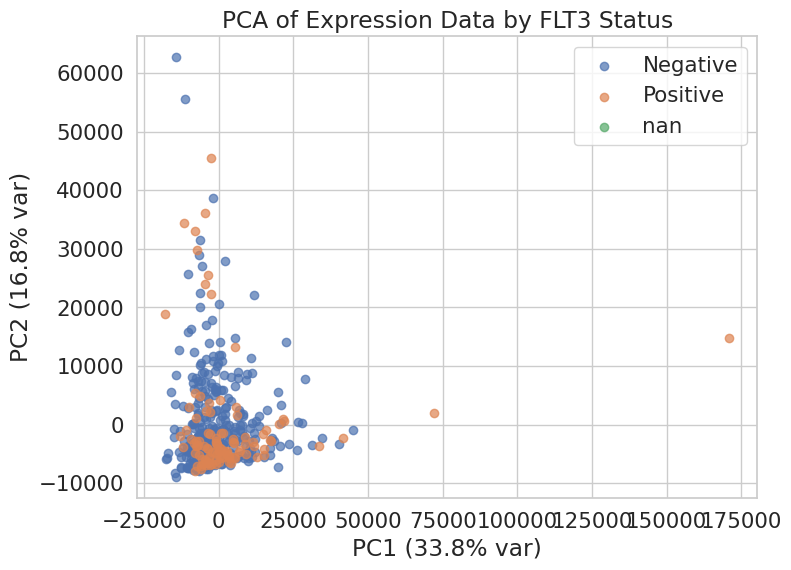

In [32]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Separate expression matrix and metadata
X = expr_merged.drop(columns=["FLT3_ITD_CONSENSUS_CALL"])
X = X.select_dtypes(include=["number"])   # keep only numeric columns
y = expr_merged["FLT3_ITD_CONSENSUS_CALL"]

# (optional) transpose if genes are rows and samples are columns
# X = X.T

# 2. Run PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 3. Make a dataframe with results
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"], index=expr_merged.index)
pca_df["FLT3_ITD_CONSENSUS_CALL"] = y.values

# Save PCA results as CSV
pca_df.to_csv("pca_results.csv")

# 4. Plot
plt.figure(figsize=(8,6))
for status in pca_df["FLT3_ITD_CONSENSUS_CALL"].unique():
    subset = pca_df[pca_df["FLT3_ITD_CONSENSUS_CALL"] == status]
    plt.scatter(subset["PC1"], subset["PC2"], label=status, alpha=0.7)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("PCA of Expression Data by FLT3 Status")
plt.legend()

# Save plot as PNG
plt.savefig("pca_plot.png", dpi=600, bbox_inches="tight")
plt.show()


In [16]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# -------------------------
# 1. Setup
# -------------------------
genes = ['CREBBP', 'STAT3', 'EP300' ]
output_folder = "pretty_gene_violin_plots_log"
os.makedirs(output_folder, exist_ok=True)

# Check if genes exist in the data
available_genes = [gene for gene in genes if gene in expr_merged.columns]
missing_genes = [gene for gene in genes if gene not in expr_merged.columns]

print(f"Available genes: {available_genes}")
if missing_genes:
    print(f"Missing genes: {missing_genes}")

# -------------------------
# 2. Melt to long format and LOG TRANSFORM
# -------------------------
df_long = expr_merged.melt(
    id_vars=['SAMPLE_ID', 'FLT3_ITD_CONSENSUS_CALL'],
    value_vars=available_genes,
    var_name='Gene',
    value_name='Expression'
)

# Remove any NaN values
df_long = df_long.dropna()

# LOG TRANSFORMATION OPTIONS:
# Option 1: log2(x + 1) - most common for RNA-seq data
df_long['Log_Expression'] = np.log2(df_long['Expression'] + 1)

# Option 2: log10(x + 1) - if you prefer log10
# df_long['Log_Expression'] = np.log10(df_long['Expression'] + 1)

# Option 3: ln(x + 1) - natural log
# df_long['Log_Expression'] = np.log(df_long['Expression'] + 1)

# Option 4: Only log transform if expression > 0, otherwise keep as 0
# df_long['Log_Expression'] = df_long['Expression'].apply(lambda x: np.log2(x) if x > 0 else 0)

print(f"Expression range: {df_long['Expression'].min():.2f} - {df_long['Expression'].max():.2f}")
print(f"Log2(x+1) range: {df_long['Log_Expression'].min():.2f} - {df_long['Log_Expression'].max():.2f}")

# -------------------------
# 3. Plot per gene with colorbar (LOG TRANSFORMED)
# -------------------------
sns.set(style="whitegrid", font_scale=1.4)

for gene in available_genes:
    subset = df_long[df_long["Gene"] == gene]

    fig, ax = plt.subplots(figsize=(7, 6))

    # Create colormap for LOG expression values
    norm = mcolors.Normalize(vmin=subset["Log_Expression"].min(), vmax=subset["Log_Expression"].max())
    cmap = cm.get_cmap("magma")
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Violin (distribution background)
    sns.violinplot(
        data=subset,
        x="FLT3_ITD_CONSENSUS_CALL",
        y="Log_Expression",  # Using log-transformed values
        inner=None,
        linewidth=0,
        palette="pastel",
        ax=ax
    )

    # Boxplot overlay
    sns.boxplot(
        data=subset,
        x="FLT3_ITD_CONSENSUS_CALL",
        y="Log_Expression",  # Using log-transformed values
        width=0.2,
        boxprops=dict(alpha=0.9),
        showcaps=True,
        fliersize=0,
        linewidth=1.5,
        color='white',
        ax=ax
    )

    # Add stripplot with color-mapped expression
    for condition in subset["FLT3_ITD_CONSENSUS_CALL"].unique():
        sub = subset[subset["FLT3_ITD_CONSENSUS_CALL"] == condition]
        x_val = list(subset["FLT3_ITD_CONSENSUS_CALL"].unique()).index(condition)
        jittered_x = x_val + 0.15 * (np.random.rand(len(sub)) - 0.5)

        ax.scatter(
            jittered_x,
            sub["Log_Expression"],  # Using log-transformed values
            c=cmap(norm(sub["Log_Expression"])),  # Color based on log values
            edgecolor="black",
            linewidth=0.4,
            s=60,
            alpha=0.85
        )

    # Title and formatting
    ax.set_title(f"{gene} Expression by FLT3_ITD Status (Log2 Scale)", fontsize=16, weight='bold')
    ax.set_xlabel("FLT3_ITD Status", fontsize=14)
    ax.set_ylabel("Log2(Expression + 1)", fontsize=14)  # Updated label

    # Add colorbar
    cbar = fig.colorbar(sm, ax=ax, pad=0.02)
    cbar.set_label("Log2(Expression + 1)", fontsize=12)  # Updated label

    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f"{gene}_violin_log_expression_colorbar.png"), dpi=600)
    plt.close()

print(f"Log-transformed plots saved in '{output_folder}' folder")

Available genes: ['CREBBP', 'STAT3', 'EP300']
Expression range: 25.23 - 845.86
Log2(x+1) range: 4.71 - 9.73


/tmp/ipython-input-1038021073.py:65: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

/tmp/ipython-input-1038021073.py:70: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-1038021073.py:65: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

/tmp/ipython-input-1038021073.py:70: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-1038021073.py:6

Log-transformed plots saved in 'pretty_gene_violin_plots_log' folder


In [29]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

# -------------------------
# Copy of your expression matrix
# -------------------------
expression = expr_merged.copy()  # Ensure this exists

# -------------------------
# Gene lists
# -------------------------
hidden_upregulated = ["TSLP","RFX2","INHA","CUX1","LTK","B3GALT1","CAMK2B","NPAS1","F3","SOHLH2"]
hidden_downregulated = ["ZNF595","FOXJ1","IRF4","ARNT2","CPS1","LPAR6","ZNF215","PLSCR1","DSP"]
overt_upregulated = ["GLI2","CFH","CYSLTR2","CLEC3B","SOCS2","PTBP3","GGT5","TRIM15","MAGED1","HOXB2"]
overt_downregulated = ["PLAG1","PFKFB2","NEDD4L","AKT3","GNG2","COL6A3","AGTPBP1","RORB","NRP2"]

hidden_genes = hidden_upregulated + hidden_downregulated
overt_genes = overt_upregulated + overt_downregulated

# -------------------------
# Output folder
# -------------------------
output_dir = "heatmaps"
os.makedirs(output_dir, exist_ok=True)

# -------------------------
# Heatmap function
# -------------------------
def make_heatmap(df, genes, up_genes, down_genes, title, output_file):
    # Keep only genes present in df
    genes_in_df = [g for g in genes if g in df.columns]
    if not genes_in_df:
        print(f"No genes found in dataframe for {title}. Skipping heatmap.")
        return

    # Extract only gene columns
    heatmap_values = df[genes_in_df].copy()

    # Z-score normalization per gene
    heatmap_values_norm = heatmap_values.apply(zscore, axis=0)
    heatmap_values_norm = heatmap_values_norm.dropna(axis=1, how='all')
    final_genes = heatmap_values_norm.columns.tolist()

    if not final_genes:
        print(f"All columns are NaN for {title}. Skipping.")
        return

    # Row colors based on sample information
    row_colors = df["FLT3_ITD_CONSENSUS_CALL"].map({"Positive": "#E24A33", "Negative": "#348ABD"})

    # Column colors for up/down regulated genes
    col_colors = []
    for g in final_genes:
        if g in up_genes:
            col_colors.append("#E24A33")  # red
        elif g in down_genes:
            col_colors.append("#348ABD")  # blue
        else:
            col_colors.append("lightgray")

    # Plot heatmap
    cg = sns.clustermap(
        heatmap_values_norm,
        cmap="vlag",
        row_colors=row_colors,
        col_colors=col_colors,
        figsize=(max(12, len(final_genes) * 0.8), min(25, heatmap_values_norm.shape[0] * 0.07)),
        method="average",
        metric="correlation",
        linewidths=0.5,
        linecolor="gray"
    )

    # Rotate x-axis labels and increase font size
    cg.ax_heatmap.set_xticklabels(cg.ax_heatmap.get_xticklabels(), rotation=90, ha="center", fontsize=18)
    cg.ax_heatmap.set_yticklabels(cg.ax_heatmap.get_yticklabels(), fontsize=16)

    # Title
    cg.ax_heatmap.set_title(title, fontsize=22, fontweight="bold", pad=20)

    # Legend outside heatmap
    handles = [
        plt.Line2D([0], [0], color="#E24A33", lw=8),
        plt.Line2D([0], [0], color="#348ABD", lw=8)
    ]
    cg.fig.legend(handles=handles, labels=["Upregulated", "Downregulated"],
                  loc="upper center", ncol=2, fontsize=18, frameon=False)

    # Save figure
    cg.savefig(output_file, dpi=600, bbox_inches="tight")
    plt.close()
    print(f"✅ Heatmap saved: {output_file}")


# -------------------------
# Generate heatmaps using expression data
# -------------------------
make_heatmap(
    expression,
    hidden_genes,
    hidden_upregulated,
    hidden_downregulated,
    "Hidden Drivers Expression Heatmap",
    os.path.join(output_dir, "heatmap_hidden_expr.png")
)

make_heatmap(
    expression,
    overt_genes,
    overt_upregulated,
    overt_downregulated,
    "Overt Drivers Expression Heatmap",
    os.path.join(output_dir, "heatmap_overt_expr.png")
)


✅ Heatmap saved: heatmaps/heatmap_hidden_expr.png
✅ Heatmap saved: heatmaps/heatmap_overt_expr.png


In [17]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import numpy as np

# -------------------------
# Copy of your expression/activity matrix
# -------------------------
expression = expr_merged.copy()  # Ensure this exists

# -------------------------
# Gene lists
# -------------------------
hidden_upregulated = ["TSLP","RFX2","INHA","CUX1","LTK","B3GALT1","CAMK2B","NPAS1","F3","SOHLH2"]
hidden_downregulated = ["ZNF595","FOXJ1","IRF4","ARNT2","CPS1","LPAR6","ZNF215","PLSCR1","DSP"]
overt_upregulated = ["GLI2","CFH","CYSLTR2","CLEC3B","SOCS2","PTBP3","GGT5","TRIM15","MAGED1","HOXB2"]
overt_downregulated = ["PLAG1","PFKFB2","NEDD4L","AKT3","GNG2","COL6A3","AGTPBP1","RORB","NRP2"]

hidden_genes = hidden_upregulated + hidden_downregulated
overt_genes = overt_upregulated + overt_downregulated

# -------------------------
# Log-transform expression values (add pseudocount 1)
# -------------------------
expression_log = expression.copy()
expression_log[hidden_genes + overt_genes] = np.log2(expression_log[hidden_genes + overt_genes] + 1)

# -------------------------
# Output folder
# -------------------------
output_dir = "heatmaps"
os.makedirs(output_dir, exist_ok=True)

# -------------------------
# Heatmap function
# -------------------------
def make_heatmap(df, genes, up_genes, down_genes, title, output_file):
    # Keep only genes present in df
    genes_in_df = [g for g in genes if g in df.columns]
    if not genes_in_df:
        print(f"No genes found in dataframe for {title}. Skipping heatmap.")
        return

    # Extract only gene columns
    heatmap_values = df[genes_in_df].copy()

    # Z-score normalization per gene
    heatmap_values_norm = heatmap_values.apply(zscore, axis=0)
    heatmap_values_norm = heatmap_values_norm.dropna(axis=1, how='all')
    final_genes = heatmap_values_norm.columns.tolist()

    if not final_genes:
        print(f"All columns are NaN for {title}. Skipping.")
        return

    # Row colors based on sample information
    row_colors = df["FLT3_ITD_CONSENSUS_CALL"].map({"Positive": "#E24A33", "Negative": "#348ABD"})

    # Column colors for up/down regulated genes
    col_colors = []
    for g in final_genes:
        if g in up_genes:
            col_colors.append("#E24A33")  # red
        elif g in down_genes:
            col_colors.append("#348ABD")  # blue
        else:
            col_colors.append("lightgray")

    # Plot heatmap
    cg = sns.clustermap(
        heatmap_values_norm,
        cmap="vlag",
        row_colors=row_colors,
        col_colors=col_colors,
        figsize=(max(12, len(final_genes) * 0.8), min(25, heatmap_values_norm.shape[0] * 0.07)),
        method="average",
        metric="correlation",
        linewidths=0.5,
        linecolor="gray"
    )

    # Rotate x-axis labels and increase font size
    cg.ax_heatmap.set_xticklabels(cg.ax_heatmap.get_xticklabels(), rotation=90, ha="center", fontsize=18)
    cg.ax_heatmap.set_yticklabels(cg.ax_heatmap.get_yticklabels(), fontsize=16)

    # Title
    cg.ax_heatmap.set_title(title, fontsize=22, fontweight="bold", pad=20)

    # Legend outside heatmap for up/down
    handles = [
        plt.Line2D([0], [0], color="#E24A33", lw=8),
        plt.Line2D([0], [0], color="#348ABD", lw=8)
    ]
    cg.fig.legend(handles=handles, labels=["Upregulated", "Downregulated"],
                  loc="upper center", ncol=2, fontsize=18, frameon=False)

    # Save figure
    cg.savefig(output_file, dpi=600, bbox_inches="tight")
    plt.close()
    print(f"✅ Heatmap saved: {output_file}")

# -------------------------
# Generate heatmaps using log2-transformed expression data
# -------------------------
make_heatmap(
    expression_log,
    hidden_genes,
    hidden_upregulated,
    hidden_downregulated,
    "Hidden Drivers Expression Heatmap (log2)",
    os.path.join(output_dir, "heatmap_hidden_expr_log2.png")
)

make_heatmap(
    expression_log,
    overt_genes,
    overt_upregulated,
    overt_downregulated,
    "Overt Drivers Expression Heatmap (log2)",
    os.path.join(output_dir, "heatmap_overt_expr_log2.png")
)


✅ Heatmap saved: heatmaps/heatmap_hidden_expr_log2.png
✅ Heatmap saved: heatmaps/heatmap_overt_expr_log2.png


Activity

In [18]:
expr = pd.read_csv('data/ac_matrix.csv',  index_col=0)  # index_col=0 makes Hugo_Symbol the index
expr.head()
# Clean the index of expr (not df!)
expr.index = expr.index.str.replace(r"_.*", "", regex=True)

# Check result
expr.head()
sample_info = pd.read_excel('data/data_clinical_sample.xlsx')  # your Excel filename
sample_info.head()

,SAMPLE_ID,FLT3_ITD_CONSENSUS_CALL,NPM1_CONSENSUS_CALL
0,aml_ohsu_2018_09.00705,Positive,Positive
1,aml_ohsu_2018_10.00136,Positive,Negative
2,aml_ohsu_2018_10.00172,Positive,Negative
3,aml_ohsu_2018_10.00507,Positive,Positive
4,aml_ohsu_2018_10.00542,Positive,Negative


In [19]:
# Undo the replacement — keep dots for consistency
sample_info['SAMPLE_ID'] = sample_info['SAMPLE_ID'].str.replace('-', '.', regex=False)

# Now filter
expr_filtered_cols = [col for col in expr.columns if col in sample_info['SAMPLE_ID'].values]
expr = expr[expr_filtered_cols]

# Transpose and merge
expr_T = expr.T
expr_T['SAMPLE_ID'] = expr_T.index
expr_merged = expr_T.merge(sample_info, on='SAMPLE_ID')
expr_merged.head()

,AATF,ADNP,ADNP2,AEBP1,AEBP2,AFF1,AFF3,AFF4,AHCTF1,AHDC1,...,ZP3,ZRANB1,ZRANB2,ZRANB3,ZRSR2,ZXDC,ZYX,SAMPLE_ID,FLT3_ITD_CONSENSUS_CALL,NPM1_CONSENSUS_CALL
0,0.224467,0.455537,-0.001314,-0.009188,0.176571,0.155185,0.063641,0.221062,0.183104,0.094491,...,-0.038021,0.085387,0.065430,0.205618,-0.035751,0.016286,0.293381,aml_ohsu_2018_12.00023,Negative,Negative
1,0.130642,0.581902,0.412469,0.109036,0.341479,0.334440,-0.056351,0.618211,0.407813,0.291012,...,-0.031342,0.458958,0.263332,0.352548,-0.077368,0.215795,0.266285,aml_ohsu_2018_12.00051,Positive,Positive
2,0.220799,0.363219,0.049668,-0.063706,0.100151,0.139463,0.015142,0.214073,0.180508,-0.063214,...,-0.043551,0.097291,0.036986,0.234734,-0.116581,0.093620,0.305377,aml_ohsu_2018_12.00066,Positive,Negative
3,0.235452,0.454843,0.221028,0.102743,0.226137,0.231403,0.068670,0.311675,0.198148,0.163128,...,0.019869,0.199534,0.073589,0.372449,-0.166400,0.063773,0.236401,aml_ohsu_2018_12.00150,Negative,Negative
4,0.243402,0.484514,0.068410,0.125421,0.258577,0.311788,-0.013981,0.293790,0.196067,0.287338,...,0.083277,0.173290,0.290183,0.510226,-0.055376,0.154590,0.161374,aml_ohsu_2018_12.00211,Negative,Positive


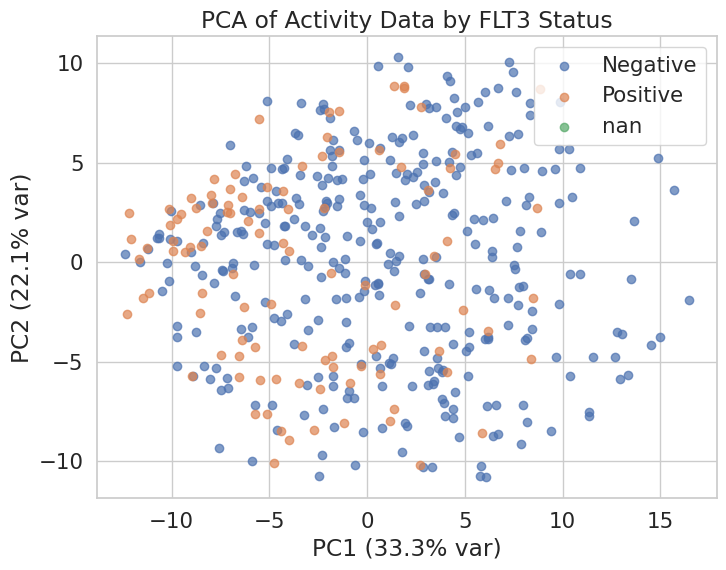

In [25]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Separate expression matrix and metadata
X = expr_merged.drop(columns=["FLT3_ITD_CONSENSUS_CALL"])
X = X.select_dtypes(include=["number"])   # keep only numeric columns
y = expr_merged["FLT3_ITD_CONSENSUS_CALL"]

# (optional) transpose if genes are rows and samples are columns
# X = X.T

# 2. Run PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 3. Make a dataframe with results
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"], index=expr_merged.index)
pca_df["FLT3_ITD_CONSENSUS_CALL"] = y.values

# Save PCA results as CSV
pca_df.to_csv("pca_results.csv")

# 4. Plot
plt.figure(figsize=(8,6))
for status in pca_df["FLT3_ITD_CONSENSUS_CALL"].unique():
    subset = pca_df[pca_df["FLT3_ITD_CONSENSUS_CALL"] == status]
    plt.scatter(subset["PC1"], subset["PC2"], label=status, alpha=0.7)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("PCA of Activity Data by FLT3 Status")
plt.legend()

# Save plot as PNG
plt.savefig("pca_plot_Activity.png", dpi=300, bbox_inches="tight")
plt.show()


In [43]:
##for DA
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np  # Added this import for np.random.rand()

# -------------------------
# 1. Setup
# -------------------------
genes = ['CREBBP', 'EP300', 'STAT3']
output_folder = "pretty_gene_violin_plots_DA"
os.makedirs(output_folder, exist_ok=True)

# Check if genes exist in the data
available_genes = [gene for gene in genes if gene in expr_merged.columns]
missing_genes = [gene for gene in genes if gene not in expr_merged.columns]

print(f"Available genes: {available_genes}")
if missing_genes:
    print(f"Missing genes: {missing_genes}")

# -------------------------
# 2. Melt to long format
# -------------------------
df_long = expr_merged.melt(
    id_vars=['SAMPLE_ID', 'FLT3_ITD_CONSENSUS_CALL'],
    value_vars=available_genes,  # Use available genes
    var_name='Gene',
    value_name='Activity'  # Changed from 'Expression' to 'Activity'
)

# Remove any NaN values
df_long = df_long.dropna()

# -------------------------
# 3. Plot per gene with colorbar
# -------------------------
sns.set(style="whitegrid", font_scale=1.4)

for gene in available_genes:  # Use available_genes
    subset = df_long[df_long["Gene"] == gene]

    fig, ax = plt.subplots(figsize=(7, 6))

    # Create colormap for activity values
    norm = mcolors.Normalize(vmin=subset["Activity"].min(), vmax=subset["Activity"].max())  # Fixed: both min and max use Activity
    cmap = cm.get_cmap("magma")
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # required for colorbar

    # Violin (distribution background)
    sns.violinplot(
        data=subset,
        x="FLT3_ITD_CONSENSUS_CALL",
        y="Activity",
        inner=None,
        linewidth=0,
        palette="pastel",
        ax=ax
    )

    # Boxplot overlay
    sns.boxplot(
        data=subset,
        x="FLT3_ITD_CONSENSUS_CALL",
        y="Activity",
        width=0.2,
        boxprops=dict(alpha=0.9),
        showcaps=True,
        fliersize=0,
        linewidth=1.5,
        color='white',
        ax=ax
    )

    # Add stripplot with color-mapped activity
    for condition in subset["FLT3_ITD_CONSENSUS_CALL"].unique():
        sub = subset[subset["FLT3_ITD_CONSENSUS_CALL"] == condition]
        x_val = list(subset["FLT3_ITD_CONSENSUS_CALL"].unique()).index(condition)
        jittered_x = x_val + 0.15 * (np.random.rand(len(sub)) - 0.5)

        ax.scatter(
            jittered_x,
            sub["Activity"],
            c=cmap(norm(sub["Activity"])),
            edgecolor="black",
            linewidth=0.4,
            s=60,
            alpha=0.85
        )

    # Title and formatting
    ax.set_title(f"{gene} Activity by FLT3_ITD Status", fontsize=16, weight='bold')
    ax.set_xlabel("FLT3_ITD Status", fontsize=14)
    ax.set_ylabel("Activity", fontsize=14)  # Changed from "Expression (CPM)" to "Activity"

    # Add colorbar
    cbar = fig.colorbar(sm, ax=ax, pad=0.02)
    cbar.set_label("Activity Level", fontsize=12)  # Changed from "Expression Level" to "Activity Level"

    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f"{gene}_violin_activity_colorbar.png"), dpi=300)
    plt.close()

print(f"Activity plots saved in '{output_folder}' folder")

Available genes: ['CREBBP', 'EP300', 'STAT3']


/tmp/ipython-input-2538956518.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("magma")
/tmp/ipython-input-2538956518.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipython-input-2538956518.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("magma")
/tmp/ipython-input-2538956518.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `

Activity plots saved in 'pretty_gene_violin_plots_DA' folder


In [33]:
# Define output path
output_txt_file = "expr_merged_act.txt"  # change path if needed

# Save as tab-delimited text
expr_merged.to_csv(output_txt_file, sep='\t', index=False)

print(f"✅ expr_merged saved as TXT: {output_txt_file}")


✅ expr_merged saved as TXT: expr_merged_act.txt


In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Copy activity matrix
activity = expr_merged.copy()

# Define hidden and overt genes
def make_heatmap(df, genes, up_genes, down_genes, title, output_file):
    # Keep only genes present in df
    genes_in_df = [g for g in genes if g in df.columns]

    # Filter dataframe
    heatmap_data = df[["SAMPLE_ID", "FLT3_ITD_CONSENSUS_CALL"] + genes_in_df].set_index("SAMPLE_ID")
    heatmap_values = heatmap_data[genes_in_df]

    # Row colors
    row_colors = heatmap_data["FLT3_ITD_CONSENSUS_CALL"].map({
        "Positive": "#E24A33",
        "Negative": "#348ABD"
    })

    # Z-score normalization per gene
    heatmap_values_norm = heatmap_values.apply(zscore, axis=0)

    # Filter up/down genes to only present ones
    up_genes_in_df = [g for g in up_genes if g in genes_in_df]
    down_genes_in_df = [g for g in down_genes if g in genes_in_df]

    # Column colors
    col_colors = []
    for g in genes_in_df:
        if g in up_genes_in_df:
            col_colors.append("#E24A33")  # red
        elif g in down_genes_in_df:
            col_colors.append("#348ABD")  # blue
        else:
            col_colors.append("lightgray")

    # Plot clustermap
    cg = sns.clustermap(
        heatmap_values_norm,
        cmap="vlag",
        row_colors=row_colors,
        col_colors=col_colors,
        figsize=(max(12, len(genes_in_df) * 0.8), min(20, heatmap_values.shape[0] * 0.05)),
        method="average",
        metric="correlation",
        linewidths=0.5,
        linecolor="gray",
        dendrogram_ratio=(0.2, 0.05),
        cbar_pos=(0.02, 0.6, 0.03, 0.25)
    )

    cg.ax_heatmap.set_title(title, fontsize=16, fontweight="bold", pad=20)
    cg.ax_heatmap.tick_params(axis="y", labelsize=4)

    cg.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"✅ Heatmap saved: {output_file}")


In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Copy activity matrix
activity = expr_merged.copy()
def make_heatmap(df, genes, up_genes, down_genes, title, output_file):
    # Keep only genes present in df
    genes_in_df = [g for g in genes if g in df.columns]

    if not genes_in_df:
        print(f"No genes found in dataframe for {title}. Skipping heatmap.")
        return

    # Filter dataframe for gene values only
    heatmap_values = df[genes_in_df].copy()

    # Z-score normalization per gene
    heatmap_values_norm = heatmap_values.apply(zscore, axis=0)
    heatmap_values_norm = heatmap_values_norm.dropna(axis=1, how='all')
    final_genes = heatmap_values_norm.columns.tolist()

    # Row colors
    row_colors = df["FLT3_ITD_CONSENSUS_CALL"].map({"Positive": "#E24A33", "Negative": "#348ABD"})

    # Column colors: assign up vs down colors
    col_colors = []
    for g in final_genes:
        if g in up_genes:
            col_colors.append("#E24A33")  # red for up
        elif g in down_genes:
            col_colors.append("#348ABD")  # blue for down
        else:
            col_colors.append("lightgray")

    # Plot clustermap
    cg = sns.clustermap(
        heatmap_values_norm,
        cmap="vlag",
        row_colors=row_colors,
        col_colors=col_colors,
        figsize=(max(12, len(final_genes) * 0.8), min(20, heatmap_values_norm.shape[0] * 0.05)),
        method="average",
        metric="correlation",
        linewidths=0.5,
        linecolor="gray"
    )

    # Add legend for up/down
    for color, label in [("#E24A33", "Upregulated"), ("#348ABD", "Downregulated")]:
        cg.ax_heatmap.bar(0, 0, color=color, label=label, linewidth=0)
    cg.ax_heatmap.legend(loc="upper right", fontsize=10)

    cg.ax_heatmap.set_title(title, fontsize=16, fontweight="bold", pad=20)
    cg.ax_heatmap.tick_params(axis="y", labelsize=4)

    cg.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"✅ Heatmap saved: {output_file}")


# Gene lists
hidden_upregulated = ["TSLP","RFX2","INHA","CUX1","LTK","B3GALT1","CAMK2B","NPAS1","F3","SOHLH2"]
hidden_downregulated = ["ZNF595","FOXJ1","IRF4","ARNT2","CPS1","LPAR6","ZNF215","PLSCR1","DSP"]
overt_upregulated = ["GLI2","CFH","CYSLTR2","CLEC3B","SOCS2","PTBP3","GGT5","TRIM15","MAGED1","HOXB2"]
overt_downregulated = ["PLAG1","PFKFB2","NEDD4L","AKT3","GNG2","COL6A3","AGTPBP1","RORB","NRP2"]

hidden_genes = hidden_upregulated + hidden_downregulated
overt_genes = overt_upregulated + overt_downregulated

# Output folder
output_dir = "heatmaps"
os.makedirs(output_dir, exist_ok=True)

# Generate heatmaps
make_heatmap(
    activity,
    hidden_genes,
    hidden_upregulated,
    hidden_downregulated,
    "Hidden Drivers Activity Heatmap",
    os.path.join(output_dir, "heatmap_hidden.png")
)

make_heatmap(
    activity,
    overt_genes,
    overt_upregulated,
    overt_downregulated,
    "Overt Drivers Activity Heatmap",
    os.path.join(output_dir, "heatmap_overt.png")
)

In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import pandas as pd

# -------------------------
# Copy of your activity matrix
# -------------------------
activity = expr_merged.copy()  # Ensure this exists

# -------------------------
# Gene lists
# -------------------------
hidden_upregulated = ["TSLP","RFX2","INHA","CUX1","LTK","B3GALT1","CAMK2B","NPAS1","F3","SOHLH2"]
hidden_downregulated = ["ZNF595","FOXJ1","IRF4","ARNT2","CPS1","LPAR6","ZNF215","PLSCR1","DSP"]
overt_upregulated = ["GLI2","CFH","CYSLTR2","CLEC3B","SOCS2","PTBP3","GGT5","TRIM15","MAGED1","HOXB2"]
overt_downregulated = ["PLAG1","PFKFB2","NEDD4L","AKT3","GNG2","COL6A3","AGTPBP1","RORB","NRP2"]

hidden_genes = hidden_upregulated + hidden_downregulated
overt_genes = overt_upregulated + overt_downregulated

# -------------------------
# Output folder
# -------------------------
output_dir = "heatmaps"
os.makedirs(output_dir, exist_ok=True)

# -------------------------
# Heatmap function
# -------------------------
def make_heatmap(df, genes, up_genes, down_genes, title, output_file):
    # Keep only genes present in df
    genes_in_df = [g for g in genes if g in df.columns]
    if not genes_in_df:
        print(f"No genes found in dataframe for {title}. Skipping heatmap.")
        return

    # Filter dataframe for gene values
    heatmap_values = df[genes_in_df].copy()

    # Z-score normalization per gene
    heatmap_values_norm = heatmap_values.apply(zscore, axis=0)
    heatmap_values_norm = heatmap_values_norm.dropna(axis=1, how='all')
    final_genes = heatmap_values_norm.columns.tolist()
    if not final_genes:
        print(f"All columns are NaN for {title}. Skipping.")
        return

    # Row colors
    row_colors = df["FLT3_ITD_CONSENSUS_CALL"].map({"Positive": "#E24A33", "Negative": "#348ABD"})

    # Column colors
    col_colors = ["#E24A33" if g in up_genes else "#348ABD" if g in down_genes else "lightgray"
                  for g in final_genes]

    # Figure size
    n_samples, n_genes = heatmap_values_norm.shape
    figsize = (max(15, n_genes * 0.9), min(25, n_samples * 0.15))

    # Plot clustermap
    cg = sns.clustermap(
        heatmap_values_norm,
        cmap="vlag",
        row_colors=row_colors,
        col_colors=col_colors,
        figsize=figsize,
        method="average",
        metric="correlation",
        linewidths=0.5,
        linecolor="gray",
        xticklabels=True,
        yticklabels=True
    )

    # Rotate x labels and increase font size
    cg.ax_heatmap.set_xticklabels(cg.ax_heatmap.get_xticklabels(), rotation=90, ha="center", fontsize=25)
    cg.ax_heatmap.set_yticklabels(cg.ax_heatmap.get_yticklabels(), fontsize=25)
    cg.ax_heatmap.tick_params(axis="both", which="major", labelsize=25)

    # Title
    cg.ax_heatmap.set_title(title, fontsize=30, fontweight="bold", pad=20)

    # Legend outside heatmap with larger letters and thicker markers
    handles = [
        plt.Line2D([0], [0], color="#E24A33", lw=15),
        plt.Line2D([0], [0], color="#348ABD", lw=15)
    ]
    legend = cg.fig.legend(
        handles=handles,
        labels=["Upregulated", "Downregulated"],
        loc="upper center",
        ncol=2,
        fontsize=25,
        frameon=False
    )

    # Enlarge the text in the legend manually
    for text in legend.get_texts():
        text.set_fontsize(30)  # all letters in legend

    # Save figure with high DPI
    cg.savefig(output_file, dpi=600, bbox_inches="tight")
    plt.close()
    print(f"✅ Heatmap saved: {output_file}")


# -------------------------
# Generate heatmaps
# -------------------------
make_heatmap(
    activity,
    hidden_genes,
    hidden_upregulated,
    hidden_downregulated,
    "Hidden Drivers Activity Heatmap",
    os.path.join(output_dir, "heatmap_hidden.png")
)

make_heatmap(
    activity,
    overt_genes,
    overt_upregulated,
    overt_downregulated,
    "Overt Drivers Activity Heatmap",
    os.path.join(output_dir, "heatmap_overt.png")
)


In [ ]:
"""
Gene Expression Heatmap Generator

This script creates clustered heatmaps for gene expression data, specifically
comparing hidden and overt driver genes in relation to FLT3-ITD mutations.
"""

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore


class GeneHeatmapGenerator:
    """Class to generate and save gene expression heatmaps."""

    def __init__(self, expression_data, output_directory="heatmaps"):
        """
        Initialize the heatmap generator.

        Args:
            expression_data (pd.DataFrame): Gene expression data with samples as rows
            output_directory (str): Directory to save heatmap files
        """
        self.activity = expression_data.copy()
        self.output_dir = output_directory
        self._create_output_directory()

        # Define gene sets
        self.gene_sets = self._define_gene_sets()

        # Color scheme
        self.colors = {
            'upregulated': '#E24A33',    # Red
            'downregulated': '#348ABD',   # Blue
            'positive': '#E24A33',        # FLT3-ITD positive
            'negative': '#348ABD',        # FLT3-ITD negative
            'neutral': 'lightgray'
        }

    def _create_output_directory(self):
        """Create output directory if it doesn't exist."""
        os.makedirs(self.output_dir, exist_ok=True)

    def _define_gene_sets(self):
        """
        Define the gene sets for analysis.

        Returns:
            dict: Dictionary containing gene lists for different categories
        """
        return {
            'hidden': {
                'upregulated': [
                    "TSLP", "RFX2", "INHA", "CUX1", "LTK",
                    "B3GALT1", "CAMK2B", "NPAS1", "F3", "SOHLH2"
                ],
                'downregulated': [
                    "ZNF595", "FOXJ1", "IRF4", "ARNT2", "CPS1",
                    "LPAR6", "ZNF215", "PLSCR1", "DSP"
                ]
            },
            'overt': {
                'upregulated': [
                    "GLI2", "CFH", "CYSLTR2", "CLEC3B", "SOCS2",
                    "PTBP3", "GGT5", "TRIM15", "MAGED1", "HOXB2"
                ],
                'downregulated': [
                    "PLAG1", "PFKFB2", "NEDD4L", "AKT3", "GNG2",
                    "COL6A3", "AGTPBP1", "RORB", "NRP2"
                ]
            }
        }

    def _get_all_genes(self, category):
        """
        Get all genes for a specific category (hidden or overt).

        Args:
            category (str): Either 'hidden' or 'overt'

        Returns:
            list: Combined list of upregulated and downregulated genes
        """
        gene_set = self.gene_sets[category]
        return gene_set['upregulated'] + gene_set['downregulated']

    def _filter_available_genes(self, genes):
        """
        Filter genes to only include those present in the expression data.

        Args:
            genes (list): List of gene names to filter

        Returns:
            list: Filtered list of genes present in the data
        """
        return [gene for gene in genes if gene in self.activity.columns]

    def _prepare_heatmap_data(self, genes):
        """
        Prepare and normalize data for heatmap visualization.

        Args:
            genes (list): List of genes to include in heatmap

        Returns:
            pd.DataFrame: Z-score normalized expression data
        """
        # Select gene expression values
        heatmap_data = self.activity[genes].copy()

        # Apply Z-score normalization per gene (across samples)
        normalized_data = heatmap_data.apply(zscore, axis=0)

        # Remove genes with all NaN values
        normalized_data = normalized_data.dropna(axis=1, how='all')

        return normalized_data

    def _create_row_colors(self):
        """
        Create row color mapping based on FLT3-ITD status.

        Returns:
            pd.Series: Color mapping for each sample
        """
        flt3_status_map = {
            "Positive": self.colors['positive'],
            "Negative": self.colors['negative']
        }
        return self.activity["FLT3_ITD_CONSENSUS_CALL"].map(flt3_status_map)

    def _create_column_colors(self, genes, upregulated_genes, downregulated_genes):
        """
        Create column color mapping based on gene regulation direction.

        Args:
            genes (list): List of genes in the heatmap
            upregulated_genes (list): List of upregulated genes
            downregulated_genes (list): List of downregulated genes

        Returns:
            list: Color list for each gene
        """
        colors = []
        for gene in genes:
            if gene in upregulated_genes:
                colors.append(self.colors['upregulated'])
            elif gene in downregulated_genes:
                colors.append(self.colors['downregulated'])
            else:
                colors.append(self.colors['neutral'])
        return colors

    def _calculate_figure_size(self, data):
        """
        Calculate appropriate figure size based on data dimensions - larger for bigger labels.

        Args:
            data (pd.DataFrame): Heatmap data

        Returns:
            tuple: Width and height for the figure
        """
        # Increased base sizes to accommodate larger labels
        width = max(16, data.shape[1] * 1.2)  # Increased from 12 and 0.8
        height = min(24, data.shape[0] * 0.08)  # Increased from 20 and 0.05
        return (width, height)

    def create_heatmap(self, category, title, output_filename):
        """
        Create and save a clustered heatmap for the specified gene category.

        Args:
            category (str): Gene category ('hidden' or 'overt')
            title (str): Title for the heatmap
            output_filename (str): Output filename for the saved plot
        """
        print(f"Creating heatmap for {category} genes...")

        # Get gene lists
        all_genes = self._get_all_genes(category)
        upregulated = self.gene_sets[category]['upregulated']
        downregulated = self.gene_sets[category]['downregulated']

        # Filter for available genes
        available_genes = self._filter_available_genes(all_genes)

        if not available_genes:
            print(f"❌ No genes found in dataframe for {title}. Skipping heatmap.")
            return

        # Prepare normalized data
        heatmap_data = self._prepare_heatmap_data(available_genes)

        if heatmap_data.empty:
            print(f"❌ All columns contain NaN values for {title}. Skipping.")
            return

        final_genes = heatmap_data.columns.tolist()

        # Create color mappings
        row_colors = self._create_row_colors()
        col_colors = self._create_column_colors(final_genes, upregulated, downregulated)

        # Calculate figure size
        figsize = self._calculate_figure_size(heatmap_data)

        # Create clustered heatmap
        cluster_grid = sns.clustermap(
            heatmap_data,
            cmap="vlag",
            row_colors=row_colors,
            col_colors=col_colors,
            figsize=figsize,
            method="average",
            metric="correlation",
            linewidths=0.5,
            linecolor="gray",
            xticklabels=True,
            yticklabels=True
        )

        # Customize appearance
        self._customize_heatmap_appearance(cluster_grid, title)

        # Save the figure
        output_path = os.path.join(self.output_dir, output_filename)
        cluster_grid.savefig(output_path, dpi=300, bbox_inches="tight")
        plt.close()

        print(f"✅ Heatmap saved: {output_path}")

    def _customize_heatmap_appearance(self, cluster_grid, title):
        """
        Customize the appearance of the heatmap with much larger labels.

        Args:
            cluster_grid: Seaborn ClusterGrid object
            title (str): Title for the heatmap
        """
        # Rotate and style x-axis labels - MUCH BIGGER
        cluster_grid.ax_heatmap.set_xticklabels(
            cluster_grid.ax_heatmap.get_xticklabels(),
            rotation=90,
            ha="center",
            fontsize=24,  # Increased from 14
            fontweight="bold"
        )

        # Style y-axis labels - MUCH BIGGER
        cluster_grid.ax_heatmap.set_yticklabels(
            cluster_grid.ax_heatmap.get_yticklabels(),
            fontsize=20,  # Increased from 12
            fontweight="bold"
        )

        # Set tick parameters - MUCH BIGGER
        cluster_grid.ax_heatmap.tick_params(axis="both", which="major", labelsize=20)

        # Add title - MUCH BIGGER
        cluster_grid.ax_heatmap.set_title(
            title,
            fontsize=36,  # Increased from 22
            fontweight="bold",
            pad=30
        )

        # Add legend
        self._add_legend(cluster_grid.fig)

    def _add_legend(self, figure):
        """
        Add legend to the heatmap figure with much larger text.

        Args:
            figure: Matplotlib figure object
        """
        legend_elements = [
            plt.Line2D([0], [0], color=self.colors['upregulated'], lw=8),  # Thicker lines
            plt.Line2D([0], [0], color=self.colors['downregulated'], lw=8)
        ]

        figure.legend(
            handles=legend_elements,
            labels=["Upregulated", "Downregulated"],
            loc="upper center",
            ncol=2,
            fontsize=24,  # Increased from 16
            frameon=False
        )

    def generate_all_heatmaps(self):
        """Generate both hidden and overt driver gene heatmaps."""
        print("Starting heatmap generation...")

        self.create_heatmap(
            category='hidden',
            title="Hidden Drivers Activity Heatmap",
            output_filename="heatmap_hidden.png"
        )

        self.create_heatmap(
            category='overt',
            title="Overt Drivers Activity Heatmap",
            output_filename="heatmap_overt.png"
        )

        print("✅ All heatmaps generated successfully!")


# Example usage
if __name__ == "__main__":
    # Assuming expr_merged exists in your environment
    # Replace with your actual expression data variable
    try:
        heatmap_generator = GeneHeatmapGenerator(expr_merged)
        heatmap_generator.generate_all_heatmaps()
    except NameError:
        print("❌ Please ensure 'expr_merged' variable exists with your expression data")
        print("   The data should be a pandas DataFrame with:")
        print("   - Samples as rows")
        print("   - Genes as columns")
        print("   - 'FLT3_ITD_CONSENSUS_CALL' column with 'Positive'/'Negative' values")

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

output_dir = "heatmaps"

png_files = [
    "heatmap_hidden.png",
    "heatmap_overt.png",
    "heatmap_hidden_expr_log2.png",
    "heatmap_overt_expr_log2.png"
]

png_paths = [os.path.join(output_dir, f) for f in png_files]

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # 2x2 grid
axes = axes.flatten()

for ax, png_path in zip(axes, png_paths):
    # Open image using PIL and resize to reduce memory
    img = Image.open(png_path)
    img.thumbnail((1200, 1200))  # Reduce size while keeping aspect ratio
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()



In [ ]:
import os

print(os.listdir("heatmaps"))


Gene set Enrichment for specific drivers

In [ ]:
pip install gseapy


In [ ]:
import gseapy as gp
import pandas as pd

# Your gene list
gene_list_of_interest = [
    "AKR7A2","AP1S1","AREL1","ATG9A","C16orf13","COX5A","DNPH1","DOCK4","FOXO3",
    "HINT2","HSPBP1","ISOC2","ITCH","ITPA","KAT6A","KIF21B","LITAF","MGST3","MTMR3",
    "NCOA1","NCOA2","NHP2","PHC2","PIAS1","PPM1B","PPP1R3B","RAF1","RFFL","RIN3",
    "RNF149","ROCK1","SEC14L1","SIPA1L1","SLC12A6","SLC25A44","SLC9A8","STK4","TGFBR1",
    "TGFBR2","TLE4","TUFM","VAMP8","XRN1"
]

# Run enrichment against GO Biological Process
enr = gp.enrichr(gene_list=gene_list_of_interest,
                 gene_sets='GO_Biological_Process_2023',  # can also be a list
                 organism='Human',
                 outdir='GSEA_results',
                 cutoff=0.5)  # adjust cutoff for significance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prepare data (top 15, reverse for horizontal bars)
df_plot = enr.res2d.sort_values('Adjusted P-value').head(15)[::-1]
df_plot['minus_log10_adj_p'] = -np.log10(df_plot['Adjusted P-value'].astype(float))

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

bar = sns.barplot(
    x='minus_log10_adj_p',
    y='Term',
    data=df_plot,
    palette="viridis_r"
)

# Add value labels
for index, value in enumerate(df_plot['minus_log10_adj_p']):
    bar.text(value + 0.1, index, f"{value:.2f}", va='center')

plt.xlabel('-log10(Adjusted P-value)', fontsize=12)
plt.ylabel('')
plt.title('Top 15 GO Biological Process Enrichments', fontsize=14)
plt.tight_layout()

# Save figure with high DPI (absolute path recommended)
output_file = 'GSEA_GO_pretty.png'
plt.savefig(output_file, dpi=600, bbox_inches='tight')  # bbox_inches ensures nothing is cut off
plt.close()  # Close the figure to ensure it's written to disk
print(f"Figure saved as {output_file}")



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import textwrap

# Select top N terms
top_n = 15
df_plot = enr.res2d.sort_values('Adjusted P-value').head(top_n)[::-1]

# Compute -log10(adjusted P-value)
df_plot['minus_log10_adj_p'] = -np.log10(df_plot['Adjusted P-value'].astype(float))

# Wrap long GO terms
max_width = 25
df_plot['Term_wrapped'] = df_plot['Term'].apply(lambda x: '\n'.join(textwrap.wrap(x, width=max_width)))

# Dynamically adjust figure height
fig_height = max(8, top_n * 0.9)  # increased scaling
fig, ax = plt.subplots(figsize=(10, fig_height))
sns.set_style("whitegrid")

# Normalize Combined Score for color mapping
norm = plt.Normalize(df_plot['Combined Score'].min(), df_plot['Combined Score'].max())
cmap = plt.cm.viridis_r

# Horizontal barplot
bars = ax.barh(
    y=df_plot['Term_wrapped'],
    width=df_plot['minus_log10_adj_p'],
    color=cmap(norm(df_plot['Combined Score'])),
    edgecolor='black'
)

# Annotate values on bars
for i, row in enumerate(df_plot.itertuples()):
    ax.text(
        row.minus_log10_adj_p + 0.1,
        i,
        f"{row.minus_log10_adj_p:.2f}",
        va='center',
        fontsize=8
    )

# Axes and title
ax.set_xlabel('-log10(Adjusted P-value)', fontsize=14)
ax.set_ylabel('')
ax.set_title(f'Top {top_n} GO Biological Process Enrichments', fontsize=16)
ax.invert_yaxis()  # Highest bars on top

# Make y-axis labels smaller and better aligned
ax.tick_params(axis='y', labelsize=8)
for label in ax.get_yticklabels():
    label.set_horizontalalignment('right')

# Add colorbar for Combined Score
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.05, pad=0.04)
cbar.set_label('Combined Score', fontsize=12)

# Adjust margins for wrapped labels
plt.subplots_adjust(left=0.4, right=0.95)

# Tweak layout
plt.tight_layout()
plt.savefig('GSEA_GO_barplot_pretty.png', dpi=600, bbox_inches='tight')
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import textwrap

# Select top N terms
top_n = 15
# Sort by Adjusted P-value and take top N (most significant first)
df_plot = enr.res2d.sort_values('Adjusted P-value').head(top_n)

# Compute -log10(adjusted P-value)
df_plot['minus_log10_adj_p'] = -np.log10(df_plot['Adjusted P-value'].astype(float))

# Wrap long GO terms
max_width = 25
df_plot['Term_wrapped'] = df_plot['Term'].apply(lambda x: '\n'.join(textwrap.wrap(x, width=max_width)))

# Dynamically adjust figure height
fig_height = max(8, top_n * 0.9)
fig, ax = plt.subplots(figsize=(10, fig_height))
sns.set_style("whitegrid")

# Normalize Combined Score for color mapping
norm = plt.Normalize(df_plot['Combined Score'].min(), df_plot['Combined Score'].max())
cmap = plt.cm.viridis_r

# Horizontal barplot
bars = ax.barh(
    y=df_plot['Term_wrapped'],
    width=df_plot['minus_log10_adj_p'],
    color=cmap(norm(df_plot['Combined Score'])),
    edgecolor='black'
)

# Annotate values on bars
for i, row in enumerate(df_plot.itertuples()):
    ax.text(
        row.minus_log10_adj_p + 0.1,
        i,
        f"{row.minus_log10_adj_p:.2f}",
        va='center',
        fontsize=8
    )

# Axes and title
ax.set_xlabel('-log10(Adjusted P-value)', fontsize=14)
ax.set_ylabel('')
ax.set_title(f'Top {top_n} GO Biological Process Enrichments (CREBBP & STAT3)', fontsize=16)

# Invert y-axis so most significant bars appear on top
ax.invert_yaxis()

# Make y-axis labels smaller and better aligned
ax.tick_params(axis='y', labelsize=8)
for label in ax.get_yticklabels():
    label.set_horizontalalignment('right')

# Add colorbar for Combined Score
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.05, pad=0.04)
cbar.set_label('Combined Score', fontsize=12)

# Adjust margins for wrapped labels
plt.subplots_adjust(left=0.4, right=0.95)

# Tweak layout
plt.tight_layout()
plt.savefig('GSEA_GO_barplot_pretty CREBBP-STAT3.png', dpi=600, bbox_inches='tight')
plt.show()


In [ ]:

# Your gene list
gene_list_of_interest = [
    "ACOT13", "AL133458.1", "APEH", "C10orf118", "C21orf33", "CCDC90B", "CHD2", "COPG2",
    "CPEB4", "DPM3", "ELL", "EXOSC1", "FOXO3", "HADHB", "HIBADH", "KAT6A", "LMTK2",
    "MAP3K2", "MCTS1", "MDH1", "MRPL12", "MRPL43", "MRPS21", "MRPS33", "NDUFB5",
    "NDUFS4", "NIPSNAP3A", "NSMCE1", "PHB1", "PHF12", "PMVK", "PSMA5", "RASA2",
    "REM2", "RP11-485G4.2", "RP11-582J16.5", "SETD1B", "SMIM11", "TMEM14C", "VAMP8",
    "WDR26", "ZNF592", "ZNF699", "ZNFX1"
]

# Run enrichment against GO Biological Process
enr = gp.enrichr(gene_list=gene_list_of_interest,
                 gene_sets='GO_Biological_Process_2023',  # can also be a list
                 organism='Human',
                 outdir='GSEA_results',
                 cutoff=0.5)  # adjust cutoff for significance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prepare data (top 15, reverse for horizontal bars)
df_plot = enr.res2d.sort_values('Adjusted P-value').head(15)[::-1]
df_plot['minus_log10_adj_p'] = -np.log10(df_plot['Adjusted P-value'].astype(float))

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

bar = sns.barplot(
    x='minus_log10_adj_p',
    y='Term',
    data=df_plot,
    palette="viridis_r"
)

# Add value labels
for index, value in enumerate(df_plot['minus_log10_adj_p']):
    bar.text(value + 0.1, index, f"{value:.2f}", va='center')

plt.xlabel('-log10(Adjusted P-value)', fontsize=12)
plt.ylabel('')
plt.title('Top 15 GO Biological Process Enrichments', fontsize=14)
plt.tight_layout()

# Save figure with high DPI (absolute path recommended)
output_file = 'GSEA_GO_pretty.png'
plt.savefig(output_file, dpi=600, bbox_inches='tight')  # bbox_inches ensures nothing is cut off
plt.close()  # Close the figure to ensure it's written to disk
print(f"Figure saved as {output_file}")



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import textwrap



# Select top N terms
top_n = 15
# Sort by Adjusted P-value and take top N (most significant first)
df_plot = enr.res2d.sort_values('Adjusted P-value').head(top_n)

# Compute -log10(adjusted P-value)
df_plot['minus_log10_adj_p'] = -np.log10(df_plot['Adjusted P-value'].astype(float))

# Wrap long GO terms
max_width = 25
df_plot['Term_wrapped'] = df_plot['Term'].apply(lambda x: '\n'.join(textwrap.wrap(x, width=max_width)))

# Dynamically adjust figure height
fig_height = max(8, top_n * 0.9)
fig, ax = plt.subplots(figsize=(10, fig_height))
sns.set_style("whitegrid")

# Normalize Combined Score for color mapping
norm = plt.Normalize(df_plot['Combined Score'].min(), df_plot['Combined Score'].max())
cmap = plt.cm.viridis_r

# Horizontal barplot
bars = ax.barh(
    y=df_plot['Term_wrapped'],
    width=df_plot['minus_log10_adj_p'],
    color=cmap(norm(df_plot['Combined Score'])),
    edgecolor='black'
)

# Annotate values on bars
for i, row in enumerate(df_plot.itertuples()):
    ax.text(
        row.minus_log10_adj_p + 0.1,
        i,
        f"{row.minus_log10_adj_p:.2f}",
        va='center',
        fontsize=8
    )

# Axes and title
ax.set_xlabel('-log10(Adjusted P-value)', fontsize=14)
ax.set_ylabel('')
ax.set_title(f'Top {top_n} GO Biological Process Enrichments (CREBBP & EP300)', fontsize=16)

# Invert y-axis so most significant bars appear on top
ax.invert_yaxis()

# Make y-axis labels smaller and better aligned
ax.tick_params(axis='y', labelsize=8)
for label in ax.get_yticklabels():
    label.set_horizontalalignment('right')

# Add colorbar for Combined Score
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.05, pad=0.04)
cbar.set_label('Combined Score', fontsize=12)

# Adjust margins for wrapped labels
plt.subplots_adjust(left=0.4, right=0.95)

# Tweak layout
plt.tight_layout()
plt.savefig('GSEA_GO_barplot_pretty CREBBP-eEP300.png', dpi=600, bbox_inches='tight')
plt.show()